## Name: Steven Olawale
## Student No: 202252703
## Course: Understanding Artificial Intelligence
## Course Code: 771763_A23_T1

### This jupyter notebook handles the code for section 2 of the summative assignment 

In [14]:
#Importing all the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import tensorflow
from tensorflow.keras.utils import get_file
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers, models, layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# The neural network is configured using a dictionary named config, which specifies key parameters for image classification.

In [28]:
config = {
    "directory": 'flower_photos',
    "num_classes": 5,
    "img_size": (180, 180),
    "batch_size": 32,  
    "epochs": 20,  # Number of Epochs
    "learning_rate": 0.01,  # Adjustable Learning Rate
    "conv_layers": [
        {"filters": 32, "kernel_size": (3, 3), "strides": 1, "padding": 'valid'},  # Adjustable kernel size, stride, and padding
        
    ],
    "dense_layers": [64],  
    "optimizer": "adam",  # Optimizer
    "train_split": 0.7,
    "val_split": 0.15,
    "metrics": ['accuracy'],
    "dropout_rate": 0.5,  # Adjustable Dropout Rate
    "pooling": "MaxPooling2D",  # Adjustable Pooling Type
    "use_batch_normalization": False,  # Aflag to enable/disable batch normalization
    "batch_normalization_momentum": 0.9  # Adjustable Batch Normalization Momentum
    
}

# The load_and_prepare_data function efficiently processes image data from a specified directory, resizing images and batching them as per given parameters. It splits the dataset into training, validation, and test sets, ensuring each is normalized and optimized for performance in TensorFlow models.

In [29]:
def load_and_prepare_data(directory, img_size, batch_size):
    """
    Function loads and prepares image data from a specified directory, and splits it into training, validation, and test datasets.

    Parameters:
    - directory: String, path to the directory containing image data.
    - img_size: Tuple, the size to which the images will be resized.
    - batch_size: Integer, the size of the batches of data.

    Returns:
    - train_ds: Dataset, training data.
    - val_ds: Dataset, validation data.
    - test_ds: Dataset, test data.
    """

    # Load the full dataset from the specified directory
    full_dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=123
    )

    # Determine the size of the full dataset
    dataset_size = full_dataset.cardinality().numpy()
    
    # Calculate the sizes for the training and validation datasets based on predefined splits in the config
    train_size = int(config['train_split'] * dataset_size)
    val_size = int(config['val_split'] * dataset_size)
    
    # Calculate the size of the test dataset
    test_size = dataset_size - train_size - val_size

    # Shuffle the full dataset and split it into training, validation, and test datasets
    full_dataset = full_dataset.shuffle(buffer_size=1000, seed=123, reshuffle_each_iteration=False)
    train_ds = full_dataset.take(train_size)
    test_val_ds = full_dataset.skip(train_size)
    val_ds = test_val_ds.take(val_size)
    test_ds = test_val_ds.skip(val_size)
    
    # Apply normalization to each dataset and configure them for performance
    # Normalization scales pixel values to the range [0, 1]
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds


# The create_model function constructs a convolutional neural network based on a specified configuration. It dynamically builds layers, including convolutional, pooling, and dense layers, and configures the model with appropriate activation functions, optimizers, and other settings, making it adaptable for various image classification tasks.

In [30]:
def create_model(config):
    """
    Function to create a convolutional neural network model based on the given configuration.

    Parameters:
    - config: Dictionary, containing the configuration settings for the model, including layer parameters and optimizer settings.

    Returns:
    - model: A Keras model compiled with the specified architecture and settings.
    """

    # Initialize a sequential model
    model = models.Sequential()
    first_layer = True

    # Add convolutional layers as defined in the config
    for layer_config in config['conv_layers']:
        # For the first layer, specify the input shape
        if first_layer:
            model.add(layers.Conv2D(
                layer_config['filters'], 
                layer_config['kernel_size'], 
                strides=layer_config['strides'],
                padding=layer_config['padding'], 
                activation='relu',
                input_shape=(config['img_size'][0], config['img_size'][1], 3)
            ))
            first_layer = False
        else:
            # Subsequent layers do not require the input shape
            model.add(layers.Conv2D(
                layer_config['filters'], 
                layer_config['kernel_size'], 
                strides=layer_config['strides'],
                padding=layer_config['padding'], 
                activation='relu'
            ))

        # Add pooling layer according to the configuration (MaxPooling or AveragePooling)
        if config['pooling'] == "MaxPooling2D":
            model.add(layers.MaxPooling2D())
        elif config['pooling'] == "AveragePooling2D":
            model.add(layers.AveragePooling2D())

        # Optionally add batch normalization layers if enabled in the config
        if config.get('use_batch_normalization', False):
            model.add(layers.BatchNormalization(momentum=config['batch_normalization_momentum']))

    # Flatten the output of the convolutional layers
    model.add(layers.Flatten())

    # Add dense layers as defined in the config
    for units in config['dense_layers']:
        model.add(layers.Dense(units, activation='relu'))

    # Add dropout layer to reduce overfitting
    model.add(layers.Dropout(config['dropout_rate']))

    # Add the output layer with softmax activation for classification
    model.add(layers.Dense(config['num_classes'], activation='softmax'))

    # Configure the optimizer based on the config settings
    optimizer = optimizers.get({
        'class_name': config["optimizer"], 
        'config': {'learning_rate': config['learning_rate']}
    })

    # Compile the model with the specified loss function and metrics
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=config['metrics'])

    return model

# The plot_conf_matrix_class_report function is designed to evaluate a trained machine learning model on a given test dataset. It outputs a confusion matrix and a detailed classification report

In [31]:
def plot_conf_matrix_class_report(model, test_ds):
    """
    Function to generate and plot a confusion matrix, and to print a classification report.

    Parameters:
    - model: Trained machine learning model.
    - test_ds: Test dataset.

    Returns:
    - None: This function does not return anything but outputs a plot and prints the classification report.
    """

    # Making predictions on the test dataset using the provided model
    test_predict_val = model.predict(test_ds)
    test_predictions = np.argmax(test_predict_val, axis=1)

    # Retrieving the true labels from the test dataset for comparison
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)

    # Generating a confusion matrix to compare true labels and predicted labels
    cm = confusion_matrix(true_labels, test_predictions)

    # Plotting the confusion matrix using Seaborn for better visualization
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')  # Setting label for x-axis
    plt.ylabel('True labels')  # Setting label for y-axis
    plt.title('Confusion Matrix')  # Adding a title to the plot
    plt.show()  # Displaying the plot

    # Generating a classification report that includes key metrics like precision, recall, and f1-score
    report = classification_report(true_labels, test_predictions, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
    print(report)  # Printing the classification report


# The plot_loss_acc_cm function is an essential tool for visualizing the performance of a neural network model trained with Keras. It provides dual plots for both training/validation loss and accuracy, offering a clear view of the model's learning progress over epochs. 

In [32]:
def plot_loss_acc_cm(history, model=None, test_ds=None):
    """
    Function to plot training/validation loss and accuracy, and optionally a confusion matrix.

    Parameters:
    - history: A Keras History object returned from the model's fit method.
    - model: (Optional) Trained machine learning model to plot the confusion matrix.
    - test_ds: (Optional) Test dataset for plotting the confusion matrix.

    Returns:
    - None: This function does not return any value but shows plots directly.
    """

    # Converting the history object into a pandas DataFrame for easy plotting
    history_df = pd.DataFrame(history.history)

    # Initiating the plot for training and validation loss
    plt.figure(figsize=(12, 5), dpi=300)
    plt.subplot(1, 2, 1)  # Creating a subplot for loss
    plt.plot(history_df["loss"], label="Training Loss")  # Plotting training loss
    plt.plot(history_df["val_loss"], label="Validation Loss")  # Plotting validation loss
    plt.title("Training and Validation Loss")  # Adding a title
    plt.xlabel("Epoch")  # Label for x-axis
    plt.ylabel("Loss (Cross Entropy)")  # Label for y-axis
    plt.legend()  # Displaying the legend

    # Initiating the plot for training and validation accuracy
    plt.subplot(1, 2, 2)  # Creating a subplot for accuracy
    plt.plot(history_df["accuracy"], label="Training Accuracy")  # Plotting training accuracy
    plt.plot(history_df["val_accuracy"], label="Validation Accuracy")  # Plotting validation accuracy
    plt.title("Training and Validation Accuracy")  # Adding a title
    plt.xlabel("Epoch")  # Label for x-axis
    plt.ylabel("Accuracy")  # Label for y-axis
    plt.legend()  # Displaying the legend
    plt.tight_layout()  # Adjusting the layout for a cleaner look
    plt.show()  # Displaying the plot

    # Checking if a model and test dataset are provided to plot the confusion matrix
    if model is not None and test_ds is not None:
        plot_conf_matrix_class_report(model, test_ds)  # Calling function to plot confusion matrix


In [33]:
# calling the load_and_prepare_data function with the specified parameters
train_ds, val_ds, test_ds = load_and_prepare_data(
    directory=config['directory'],   # Specifying the directory path from the configuration
    img_size=config['img_size'],     # Specifying the image size from the configuration
    batch_size=config['batch_size']  # Specifying the batch size from the configuration
)

Found 3670 files belonging to 5 classes.


In [34]:
#calling the create_model function with the specified configuration
model = create_model(config)

# Baseline Model

In [14]:
# Training the model with the specified training and validation datasets.
# The number of training cycles (epochs) is determined by the configuration.
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset for performance evaluation
    epochs=config['epochs']  # Number of epochs to train the model
)

Epoch 1/20
80/80 [==============================] - 50s 337ms/step - loss: 3.9345 - accuracy: 0.2239 - val_loss: 1.5997 - val_accuracy: 0.2610
Epoch 2/20
80/80 [==============================] - 23s 290ms/step - loss: 1.5883 - accuracy: 0.2639 - val_loss: 1.5908 - val_accuracy: 0.3621
Epoch 3/20
80/80 [==============================] - 21s 268ms/step - loss: 1.5574 - accuracy: 0.3043 - val_loss: 1.4446 - val_accuracy: 0.4081
Epoch 4/20
80/80 [==============================] - 22s 270ms/step - loss: 1.3819 - accuracy: 0.4106 - val_loss: 1.2374 - val_accuracy: 0.4871
Epoch 5/20
80/80 [==============================] - 22s 271ms/step - loss: 1.1432 - accuracy: 0.5435 - val_loss: 1.2412 - val_accuracy: 0.4963
Epoch 6/20
80/80 [==============================] - 21s 265ms/step - loss: 0.9908 - accuracy: 0.6314 - val_loss: 1.0780 - val_accuracy: 0.5901
Epoch 7/20
80/80 [==============================] - 22s 275ms/step - loss: 0.7623 - accuracy: 0.7286 - val_loss: 0.9826 - val_accuracy: 0.7059

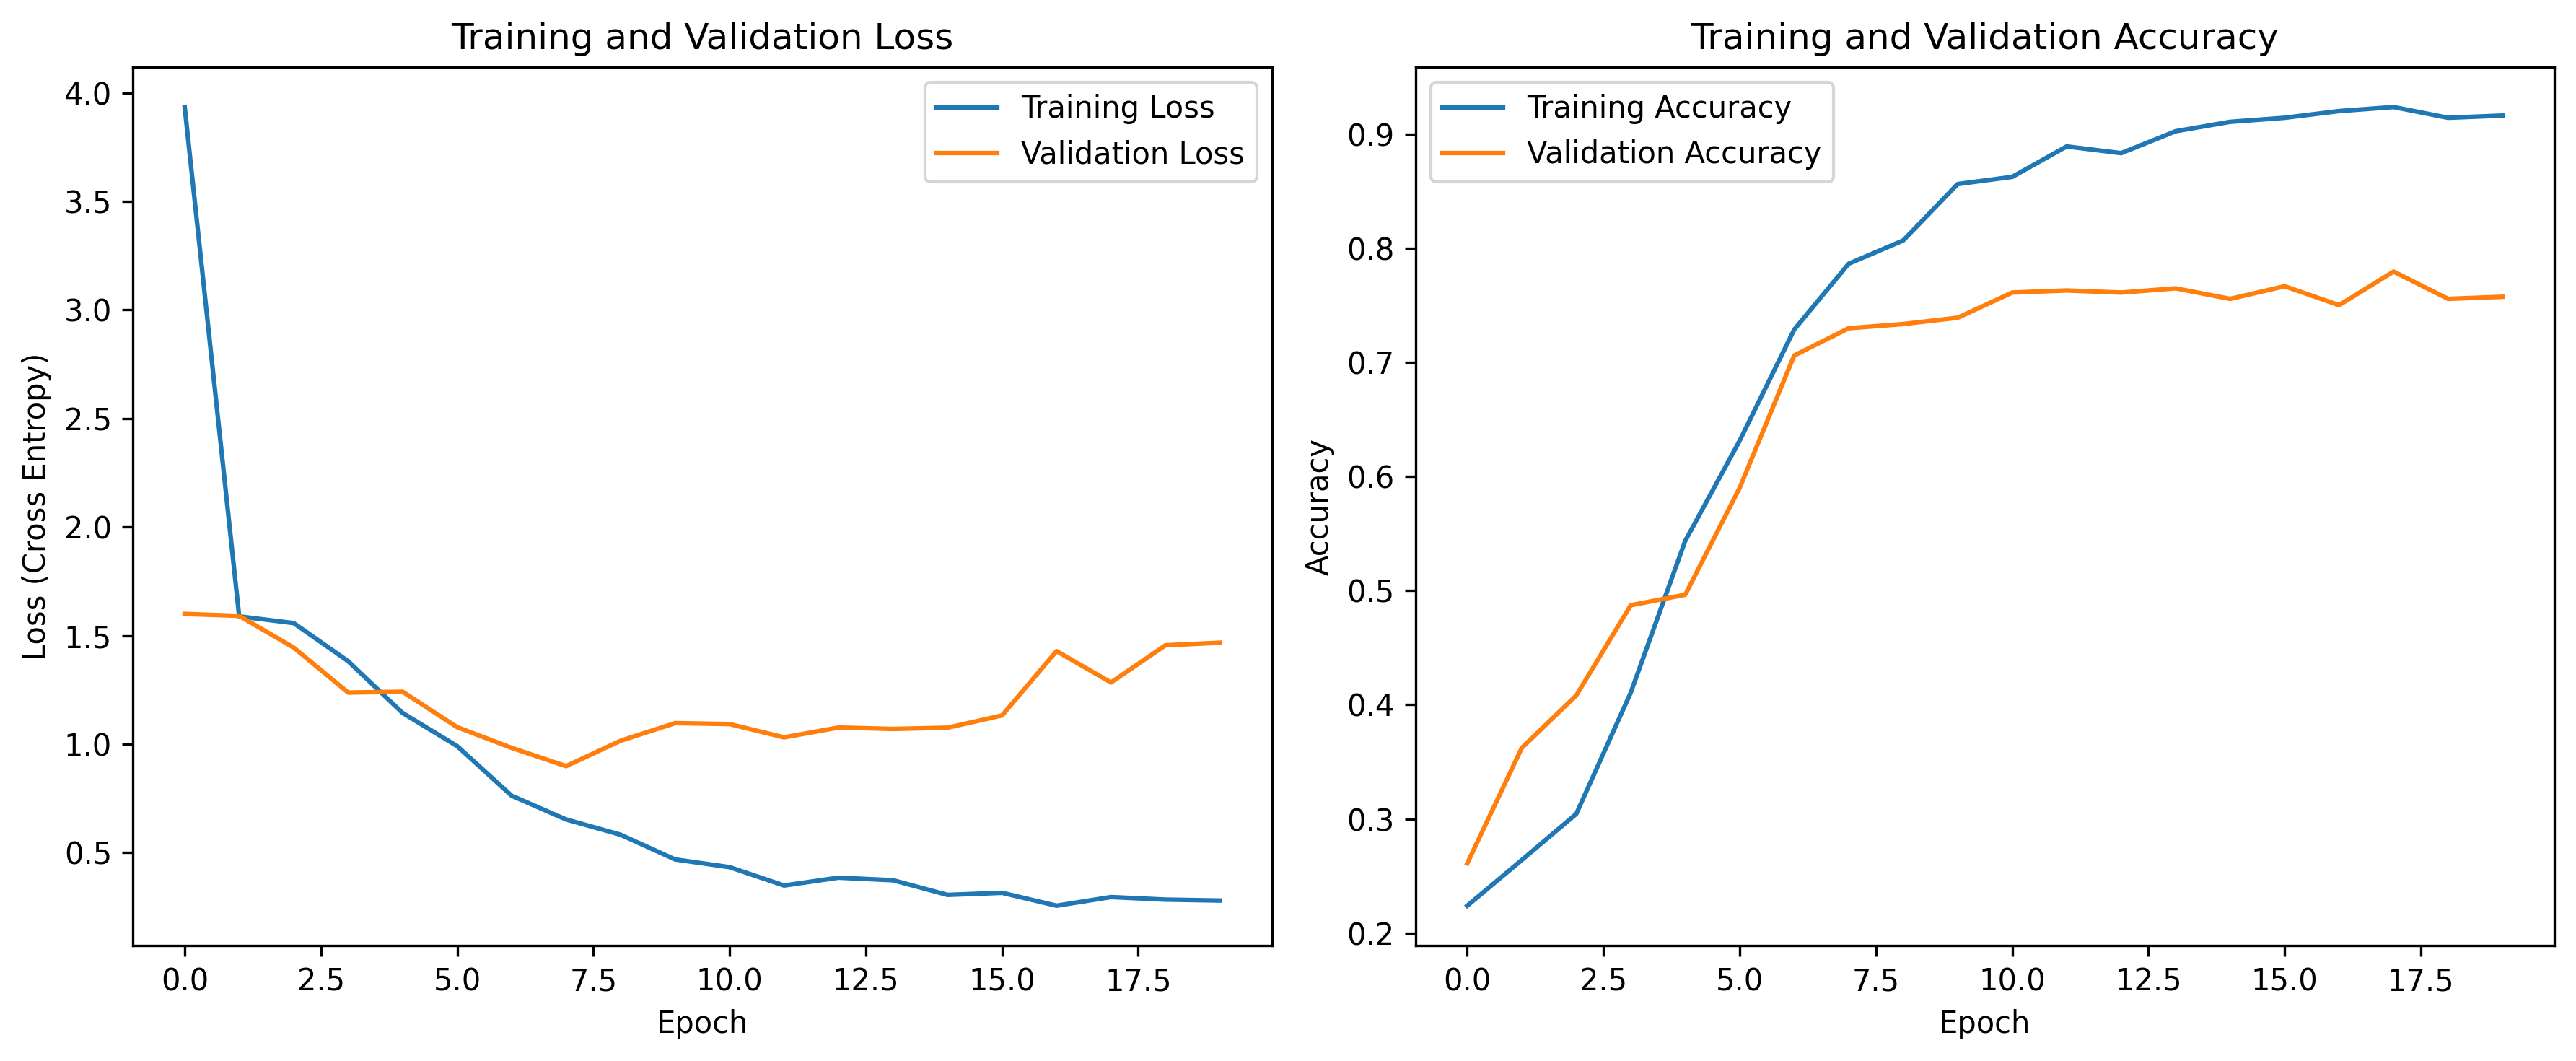

18/18 [==============================] - 2s 85ms/step


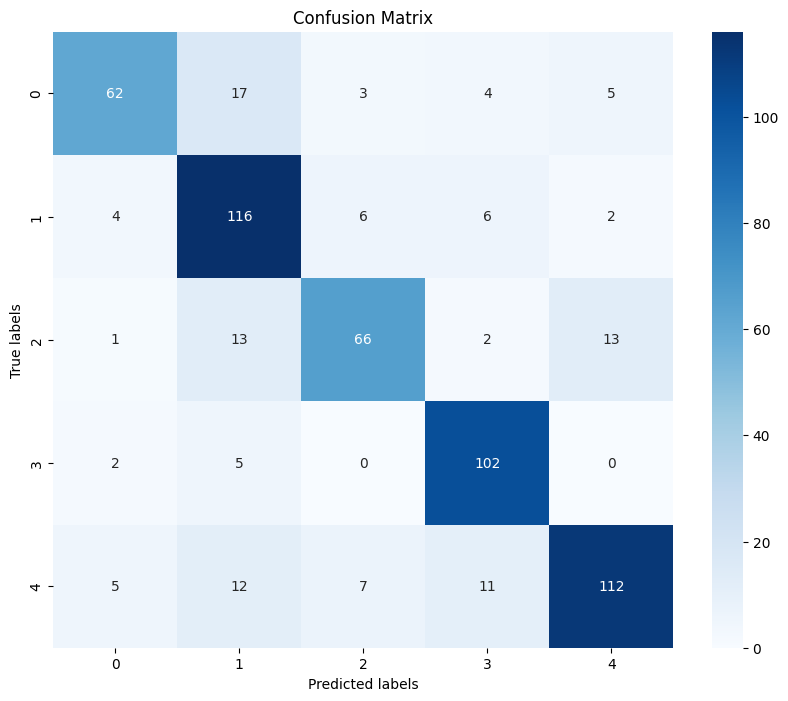

              precision    recall  f1-score   support

     Class 0       0.84      0.68      0.75        91
     Class 1       0.71      0.87      0.78       134
     Class 2       0.80      0.69      0.75        95
     Class 3       0.82      0.94      0.87       109
     Class 4       0.85      0.76      0.80       147

    accuracy                           0.80       576
   macro avg       0.80      0.79      0.79       576
weighted avg       0.80      0.80      0.79       576



In [22]:
# calling the function to plot loss, accuracy, and the confusion matrix.
plot_loss_acc_cm(history, model, test_ds)

## Batch size increased from 32 to 128 to optimize training efficiency and model performance.

In [29]:
# Increasing the batch size in the config file to 128
config['batch_size'] = 128
print (config)

{'directory': 'flower_photos', 'num_classes': 5, 'img_size': (180, 180), 'batch_size': 128, 'epochs': 20, 'learning_rate': 0.01, 'conv_layers': [{'filters': 32, 'kernel_size': (3, 3), 'strides': 1, 'padding': 'valid'}], 'dense_layers': [64], 'optimizer': 'adam', 'train_split': 0.7, 'val_split': 0.15, 'metrics': ['accuracy'], 'dropout_rate': 0.5, 'pooling': 'MaxPooling2D', 'use_batch_normalization': False, 'batch_normalization_momentum': 0.9}


In [30]:
# calling the load_and_prepare_data function with the specified parameters
train_ds, val_ds, test_ds = load_and_prepare_data(
    directory=config['directory'],   # Specifying the directory path from the configuration
    img_size=config['img_size'],     # Specifying the image size from the configuration
    batch_size=config['batch_size']  # Specifying the batch size from the configuration
)

Found 3670 files belonging to 5 classes.


In [31]:
#calling the create_model function with the specified configuration
model = create_model(config)

In [32]:
# Training the model with the specified training and validation datasets.
# The number of training cycles (epochs) is determined by the configuration.
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset for performance evaluation
    epochs=config['epochs']  # Number of epochs to train the model
)

Epoch 1/20
20/20 [==============================] - 27s 1s/step - loss: 21.4116 - accuracy: 0.2605 - val_loss: 1.6032 - val_accuracy: 0.2793
Epoch 2/20
20/20 [==============================] - 19s 968ms/step - loss: 1.6030 - accuracy: 0.2458 - val_loss: 1.5925 - val_accuracy: 0.2715
Epoch 3/20
20/20 [==============================] - 18s 928ms/step - loss: 1.5938 - accuracy: 0.2454 - val_loss: 1.5603 - val_accuracy: 0.3320
Epoch 4/20
20/20 [==============================] - 18s 919ms/step - loss: 1.5453 - accuracy: 0.3058 - val_loss: 1.4515 - val_accuracy: 0.4336
Epoch 5/20
20/20 [==============================] - 18s 898ms/step - loss: 1.3944 - accuracy: 0.4146 - val_loss: 1.3844 - val_accuracy: 0.4512
Epoch 6/20
20/20 [==============================] - 19s 936ms/step - loss: 1.2076 - accuracy: 0.5234 - val_loss: 1.2280 - val_accuracy: 0.5762
Epoch 7/20
20/20 [==============================] - 18s 905ms/step - loss: 1.0118 - accuracy: 0.6009 - val_loss: 1.0961 - val_accuracy: 0.6523
E

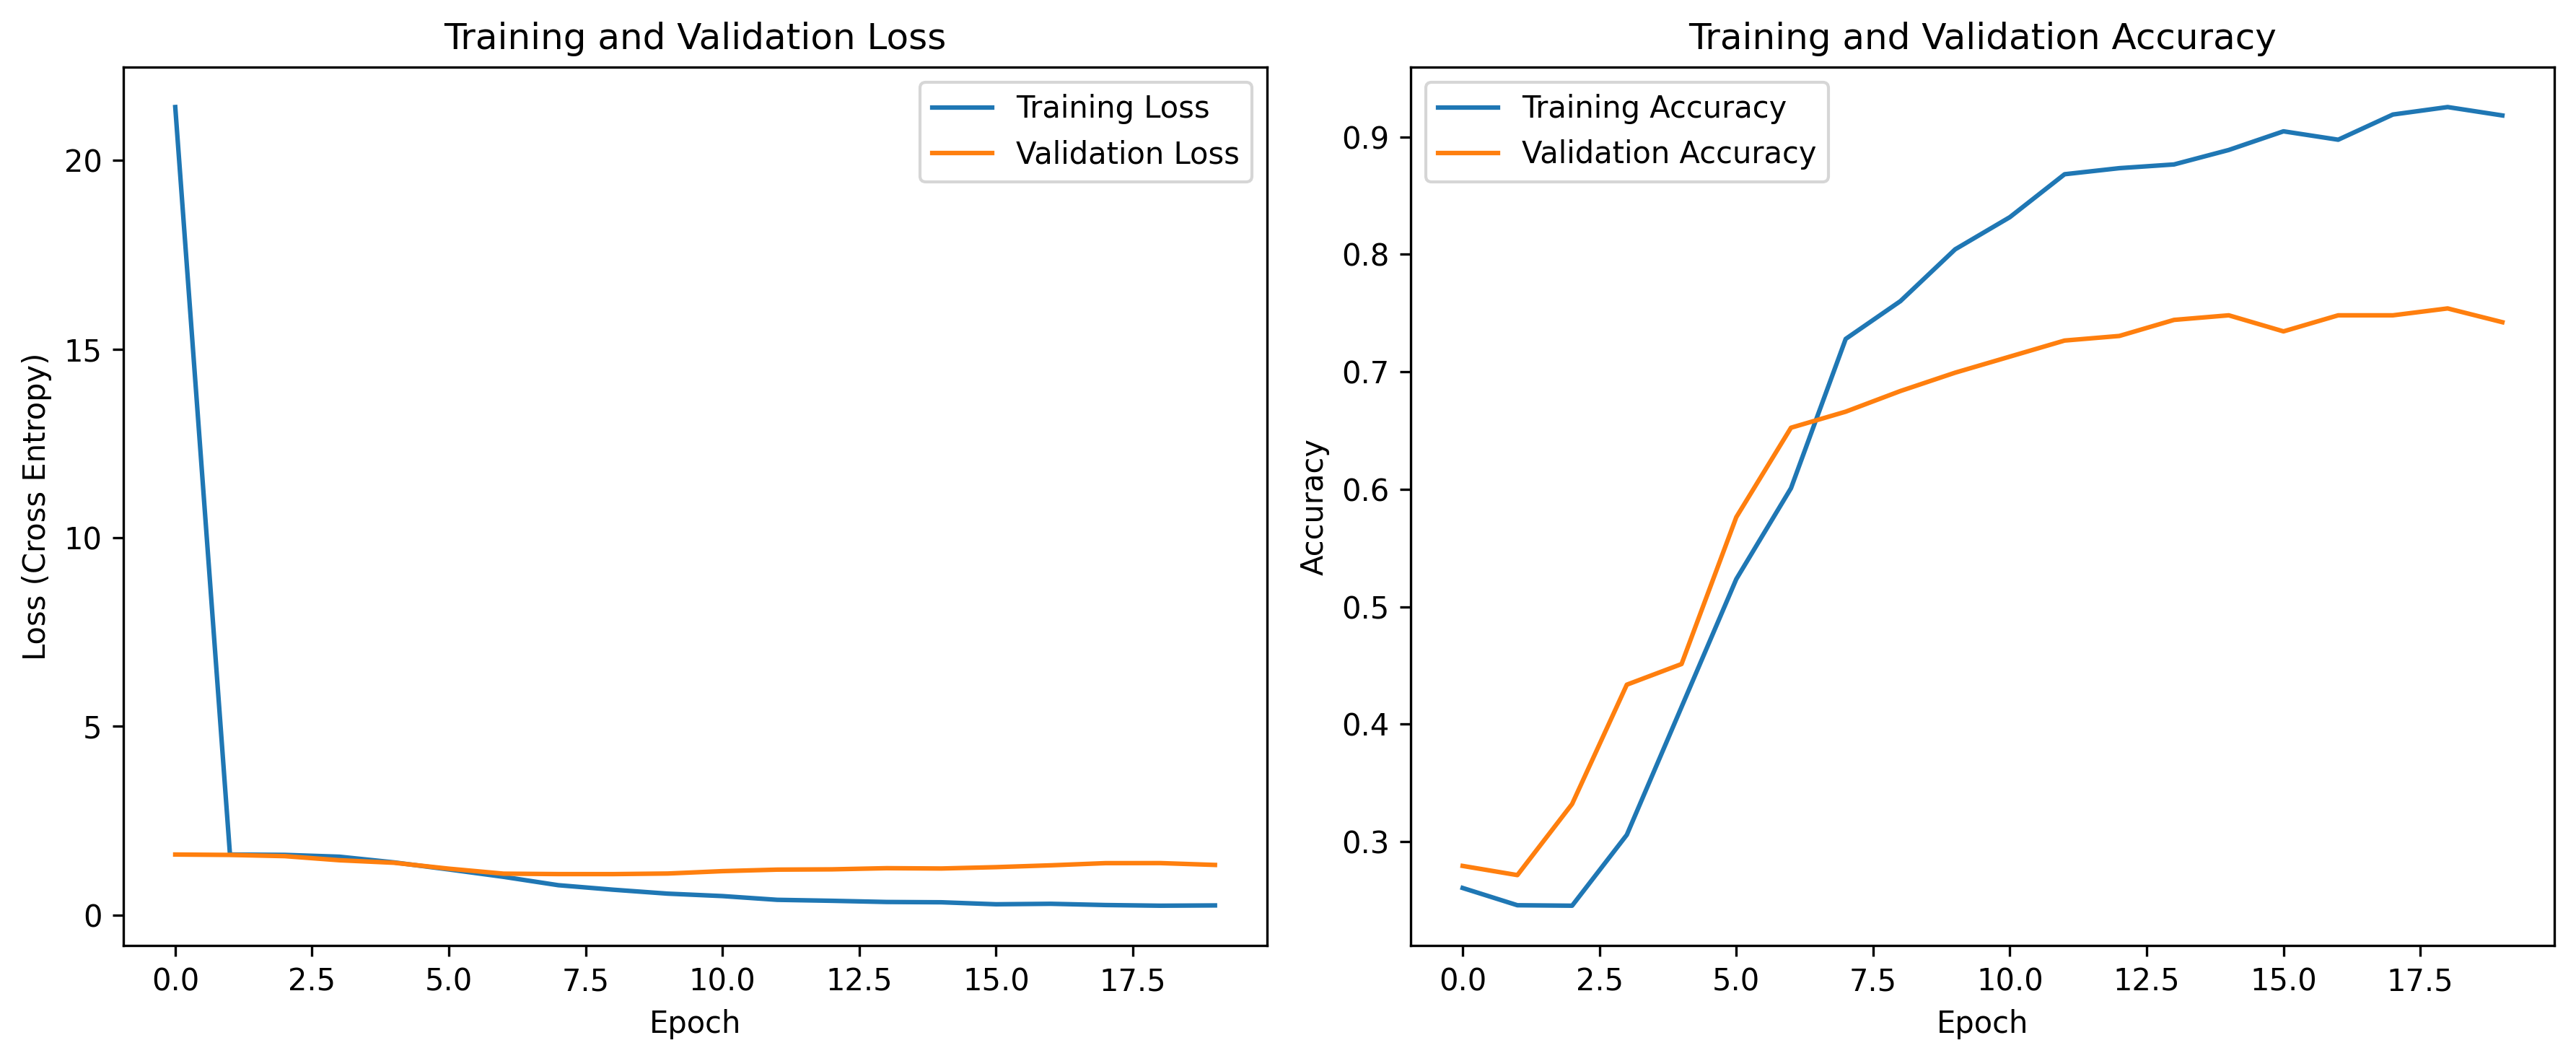

5/5 [==============================] - 20s 301ms/step


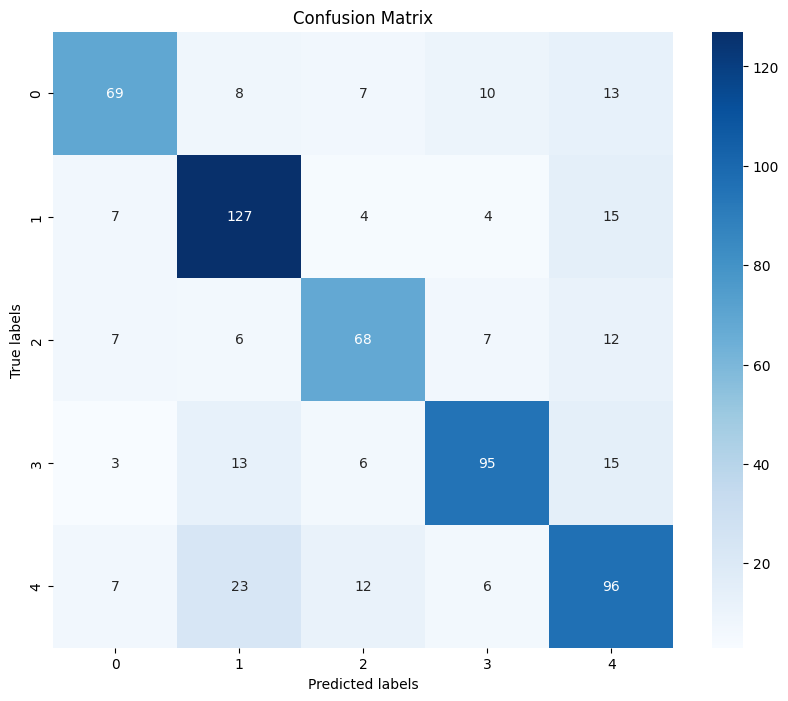

              precision    recall  f1-score   support

     Class 0       0.74      0.64      0.69       107
     Class 1       0.72      0.81      0.76       157
     Class 2       0.70      0.68      0.69       100
     Class 3       0.78      0.72      0.75       132
     Class 4       0.64      0.67      0.65       144

    accuracy                           0.71       640
   macro avg       0.71      0.70      0.71       640
weighted avg       0.71      0.71      0.71       640



In [33]:
# calling the function to plot loss, accuracy, and the confusion matrix.
plot_loss_acc_cm(history, model, test_ds)

## Reverted batch size back to 32 and enabled batch normalization with a momentum of 0.9 to stabilize learning and improve generalization. 

In [37]:
# Reducing Batch Size back to 32
config['batch_size'] = 32

In [42]:
config

{'directory': 'flower_photos',
 'num_classes': 5,
 'img_size': (180, 180),
 'batch_size': 32,
 'epochs': 20,
 'learning_rate': 0.01,
 'conv_layers': [{'filters': 32,
   'kernel_size': (5, 5),
   'strides': 1,
   'padding': 'valid'}],
 'dense_layers': [64],
 'optimizer': 'adam',
 'train_split': 0.7,
 'val_split': 0.15,
 'metrics': ['accuracy'],
 'dropout_rate': 0.5,
 'pooling': 'MaxPooling2D',
 'use_batch_normalization': False,
 'batch_normalization_momentum': 0.9}

In [44]:
# Enabling batch size in the config file
config['use_batch_normalization'] = True

In [45]:
# calling the load_and_prepare_data function with the specified parameters
train_ds, val_ds, test_ds = load_and_prepare_data(
    directory=config['directory'],   # Specifying the directory path from the configuration
    img_size=config['img_size'],     # Specifying the image size from the configuration
    batch_size=config['batch_size']  # Specifying the batch size from the configuration
)

Found 3670 files belonging to 5 classes.


In [46]:
#calling the create_model function with the specified configuration
model = create_model(config)

In [47]:
# Training the model with the specified training and validation datasets.
# The number of training cycles (epochs) is determined by the configuration.
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset for performance evaluation
    epochs=config['epochs']  # Number of epochs to train the model
)

Epoch 1/20
80/80 [==============================] - 30s 334ms/step - loss: 30.9073 - accuracy: 0.2431 - val_loss: 1.6027 - val_accuracy: 0.2537
Epoch 2/20
80/80 [==============================] - 24s 295ms/step - loss: 1.6043 - accuracy: 0.2380 - val_loss: 1.6036 - val_accuracy: 0.2537
Epoch 3/20
80/80 [==============================] - 25s 315ms/step - loss: 1.6183 - accuracy: 0.2380 - val_loss: 1.6033 - val_accuracy: 0.2537
Epoch 4/20
80/80 [==============================] - 23s 292ms/step - loss: 1.6036 - accuracy: 0.2384 - val_loss: 1.6039 - val_accuracy: 0.2537
Epoch 5/20
80/80 [==============================] - 24s 304ms/step - loss: 1.6033 - accuracy: 0.2384 - val_loss: 1.6049 - val_accuracy: 0.2537
Epoch 6/20
80/80 [==============================] - 24s 303ms/step - loss: 1.6036 - accuracy: 0.2384 - val_loss: 1.6045 - val_accuracy: 0.2537
Epoch 7/20
80/80 [==============================] - 25s 307ms/step - loss: 1.6039 - accuracy: 0.2384 - val_loss: 1.6031 - val_accuracy: 0.253

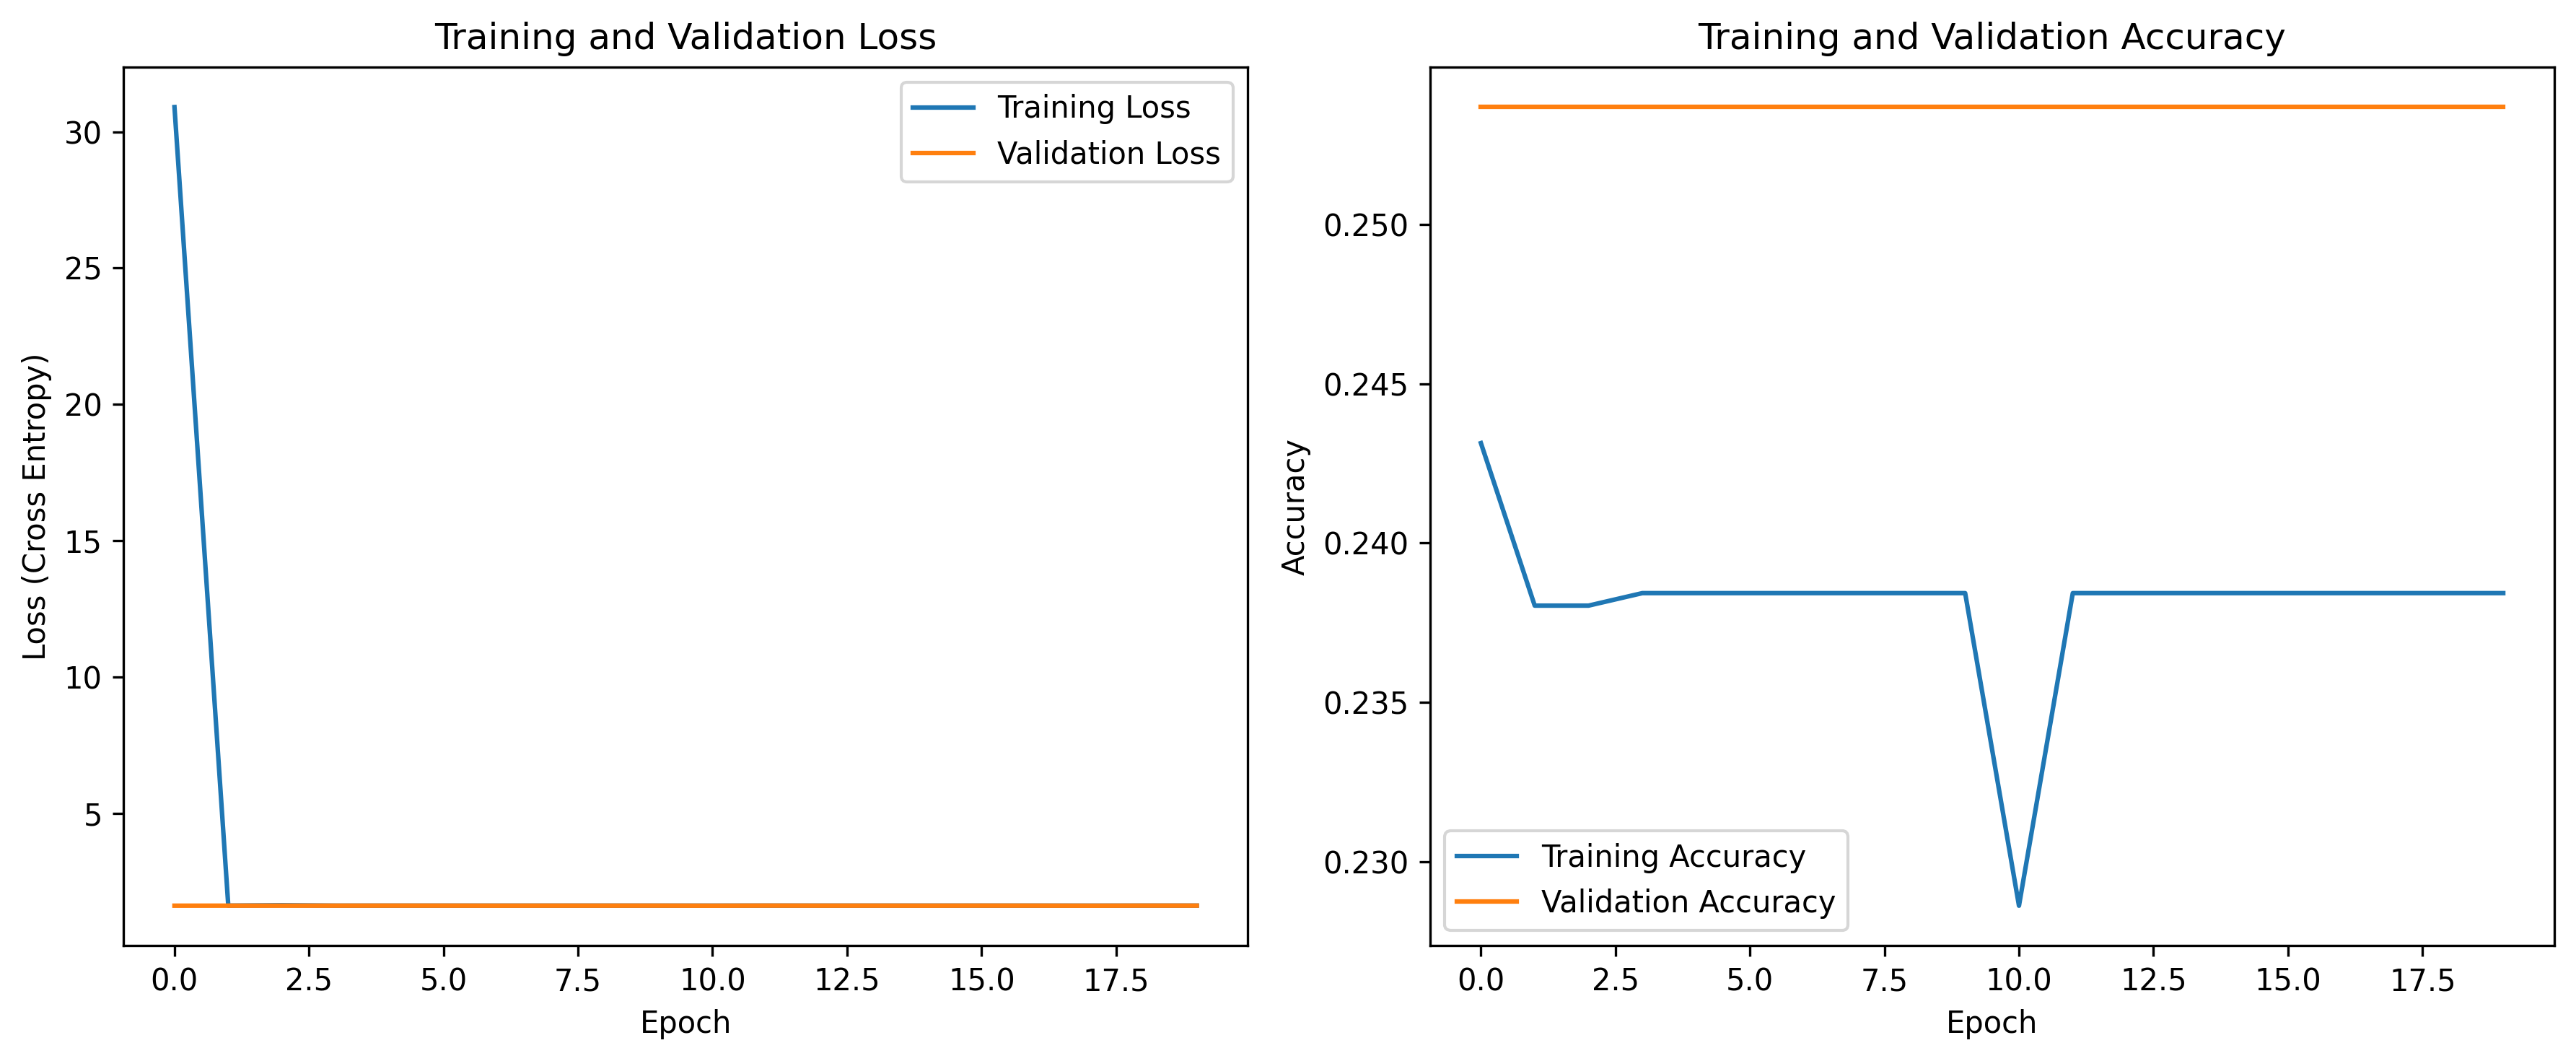

18/18 [==============================] - 23s 90ms/step


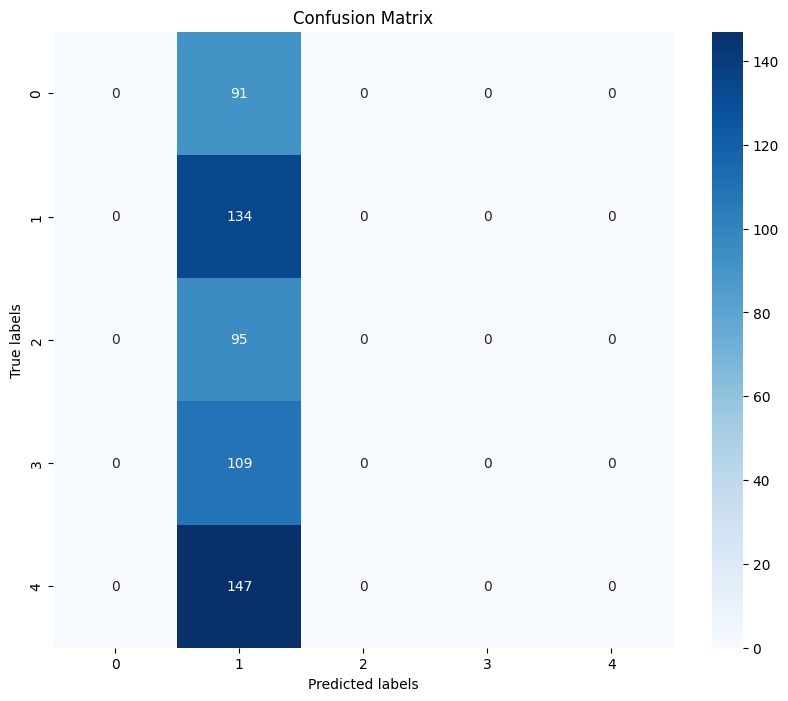

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        91
     Class 1       0.23      1.00      0.38       134
     Class 2       0.00      0.00      0.00        95
     Class 3       0.00      0.00      0.00       109
     Class 4       0.00      0.00      0.00       147

    accuracy                           0.23       576
   macro avg       0.05      0.20      0.08       576
weighted avg       0.05      0.23      0.09       576



C:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
# calling the function to plot loss, accuracy, and the confusion matrix.
plot_loss_acc_cm(history, model, test_ds)

## Reduced the learning rate to 0.0001 to promote more precise model updates and potentially better convergence.

In [49]:
config

{'directory': 'flower_photos',
 'num_classes': 5,
 'img_size': (180, 180),
 'batch_size': 32,
 'epochs': 20,
 'learning_rate': 0.01,
 'conv_layers': [{'filters': 32,
   'kernel_size': (2, 2),
   'strides': 1,
   'padding': 'valid'}],
 'dense_layers': [64],
 'optimizer': 'adam',
 'train_split': 0.7,
 'val_split': 0.15,
 'metrics': ['accuracy'],
 'dropout_rate': 0.5,
 'pooling': 'MaxPooling2D',
 'use_batch_normalization': True,
 'batch_normalization_momentum': 0.9}

In [50]:
# Changing batch normalization back to false
config['use_batch_normalization'] = False
config

{'directory': 'flower_photos',
 'num_classes': 5,
 'img_size': (180, 180),
 'batch_size': 32,
 'epochs': 20,
 'learning_rate': 0.01,
 'conv_layers': [{'filters': 32,
   'kernel_size': (2, 2),
   'strides': 1,
   'padding': 'valid'}],
 'dense_layers': [64],
 'optimizer': 'adam',
 'train_split': 0.7,
 'val_split': 0.15,
 'metrics': ['accuracy'],
 'dropout_rate': 0.5,
 'pooling': 'MaxPooling2D',
 'use_batch_normalization': False,
 'batch_normalization_momentum': 0.9}

In [51]:
## reduce learning rate
config['learning_rate'] = 0.0001

In [52]:
# calling the load_and_prepare_data function with the specified parameters
train_ds, val_ds, test_ds = load_and_prepare_data(
    directory=config['directory'],   # Specifying the directory path from the configuration
    img_size=config['img_size'],     # Specifying the image size from the configuration
    batch_size=config['batch_size']  # Specifying the batch size from the configuration
)

Found 3670 files belonging to 5 classes.


In [53]:
#calling the create_model function with the specified configuration
model = create_model(config)

In [54]:
# Training the model with the specified training and validation datasets.
# The number of training cycles (epochs) is determined by the configuration.
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset for performance evaluation
    epochs=config['epochs']  # Number of epochs to train the model
)

Epoch 1/20
80/80 [==============================] - 42s 297ms/step - loss: 1.6896 - accuracy: 0.2682 - val_loss: 1.5324 - val_accuracy: 0.3290
Epoch 2/20
80/80 [==============================] - 21s 264ms/step - loss: 1.5402 - accuracy: 0.3098 - val_loss: 1.4492 - val_accuracy: 0.3879
Epoch 3/20
80/80 [==============================] - 21s 265ms/step - loss: 1.5117 - accuracy: 0.3169 - val_loss: 1.4286 - val_accuracy: 0.4430
Epoch 4/20
80/80 [==============================] - 21s 266ms/step - loss: 1.4707 - accuracy: 0.3475 - val_loss: 1.3881 - val_accuracy: 0.3621
Epoch 5/20
80/80 [==============================] - 21s 260ms/step - loss: 1.4363 - accuracy: 0.3427 - val_loss: 1.3454 - val_accuracy: 0.4026
Epoch 6/20
80/80 [==============================] - 21s 267ms/step - loss: 1.4017 - accuracy: 0.3447 - val_loss: 1.2457 - val_accuracy: 0.5000
Epoch 7/20
80/80 [==============================] - 21s 267ms/step - loss: 1.3724 - accuracy: 0.3710 - val_loss: 1.2171 - val_accuracy: 0.5055

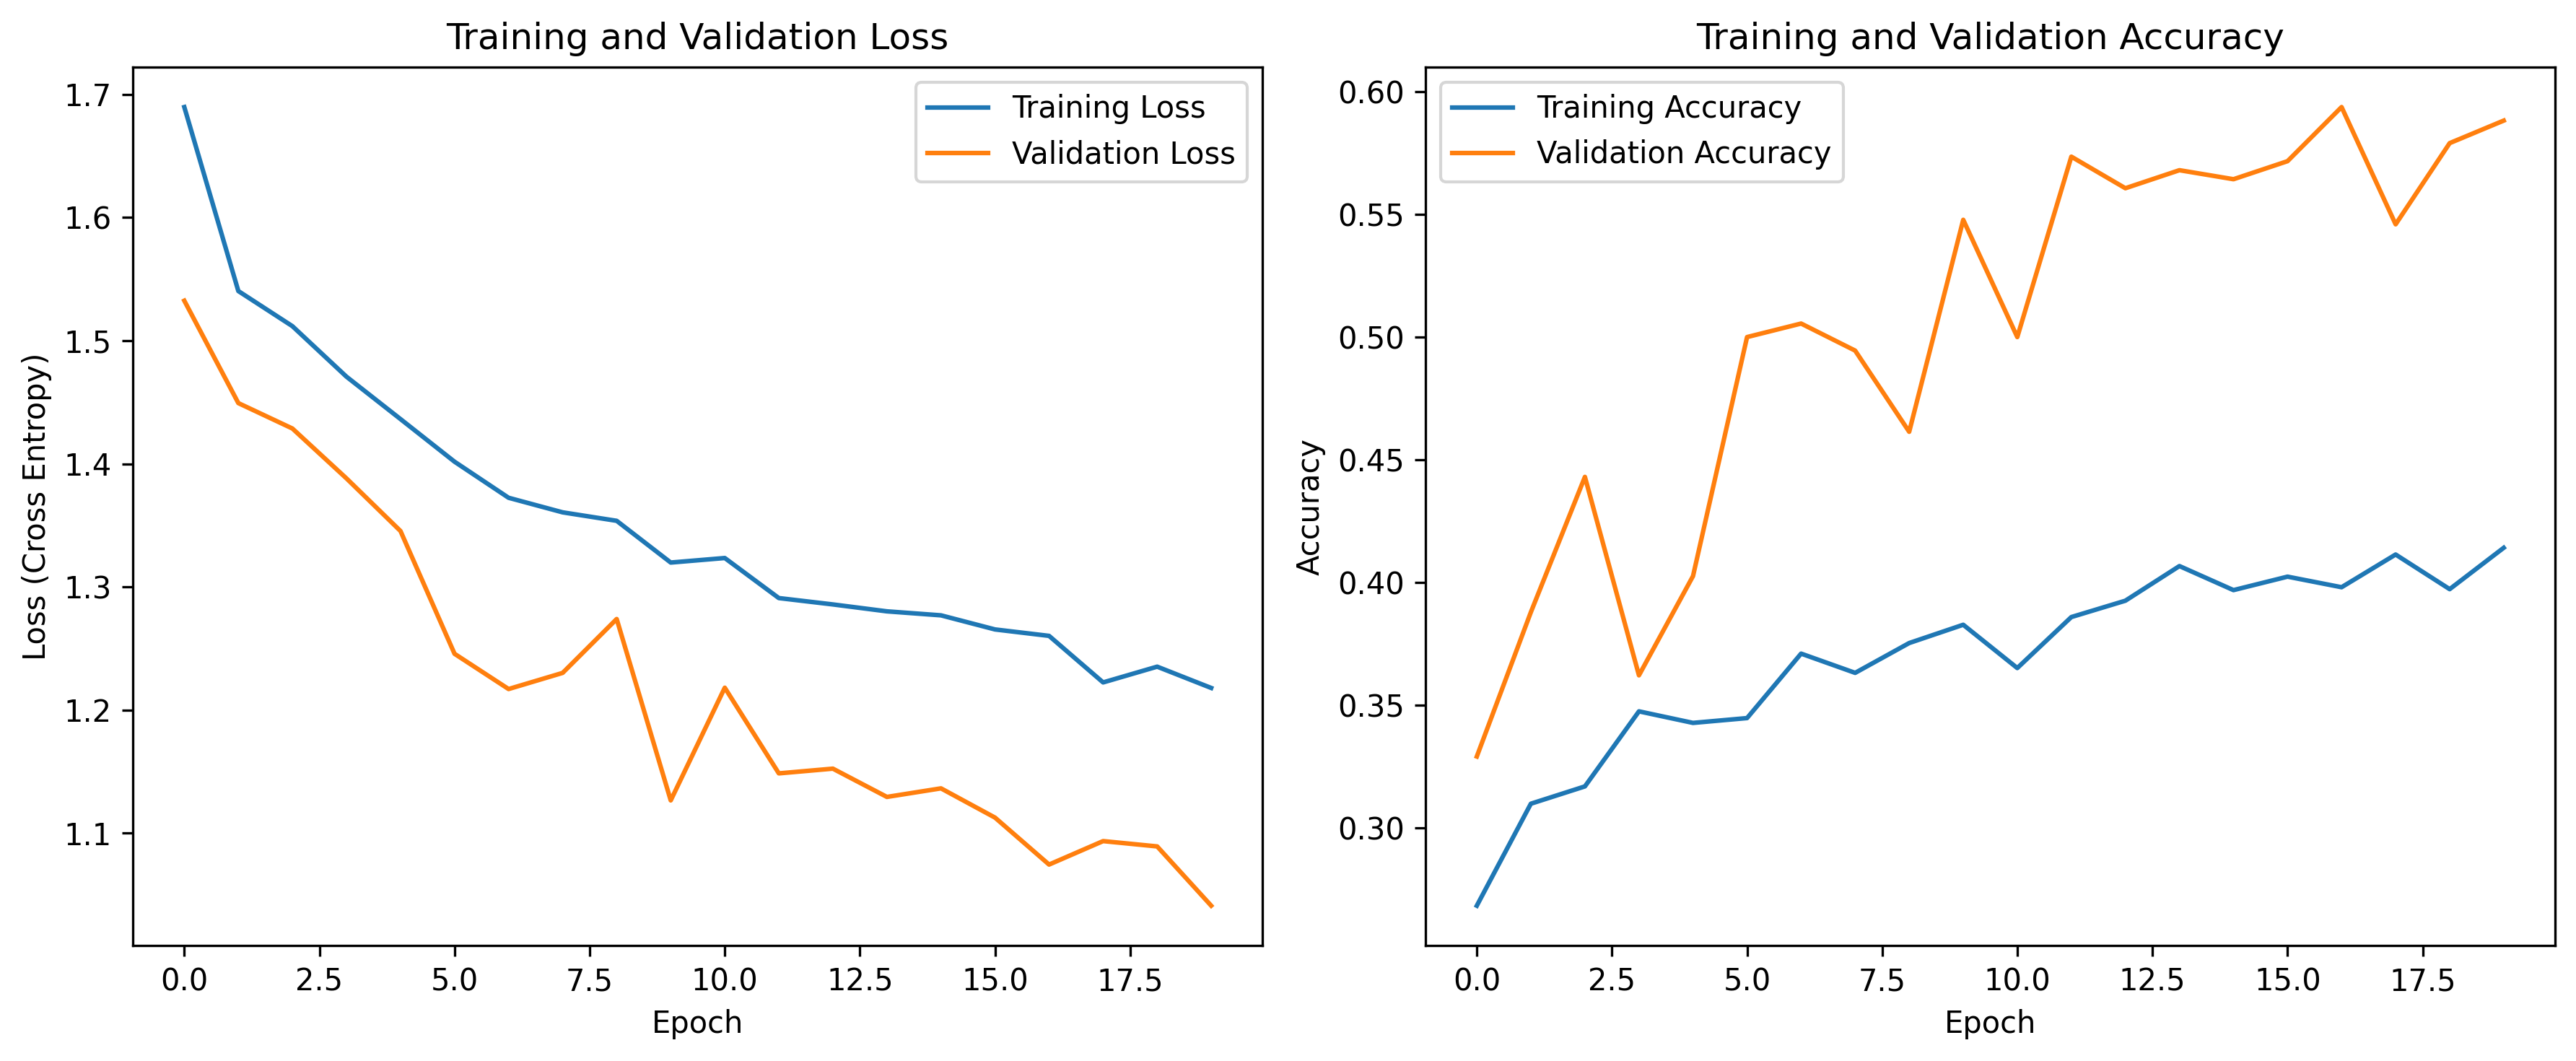

18/18 [==============================] - 20s 71ms/step


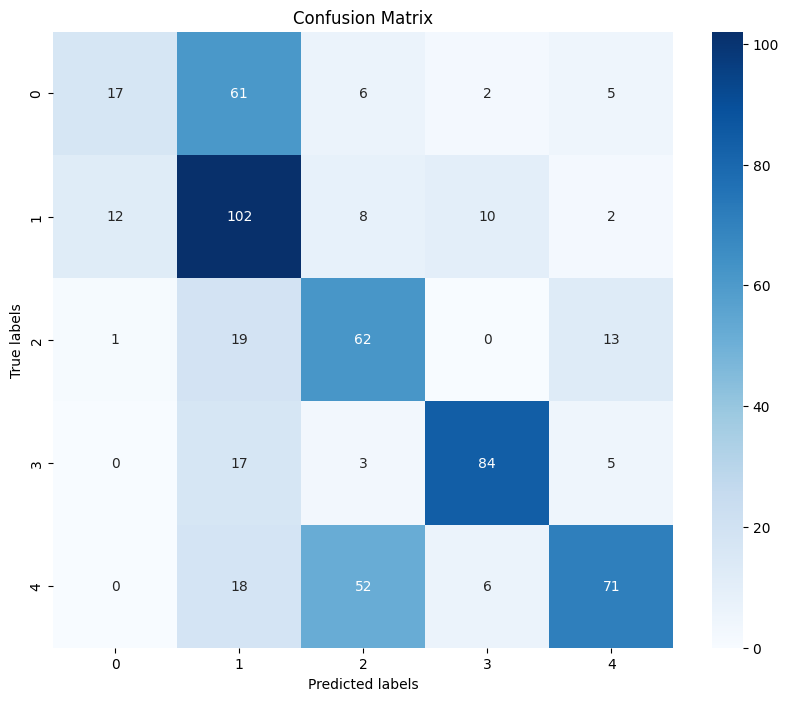

              precision    recall  f1-score   support

     Class 0       0.57      0.19      0.28        91
     Class 1       0.47      0.76      0.58       134
     Class 2       0.47      0.65      0.55        95
     Class 3       0.82      0.77      0.80       109
     Class 4       0.74      0.48      0.58       147

    accuracy                           0.58       576
   macro avg       0.61      0.57      0.56       576
weighted avg       0.62      0.58      0.57       576



In [55]:
# calling the function to plot loss, accuracy, and the confusion matrix.
plot_loss_acc_cm(history, model, test_ds)

## Dropout Rate: Reduced to 0.2 to decrease the amount of regularization, potentially allowing the model to retain more information during training while Learning Rate is Increased to 0.0008 to accelerate the learning process

In [56]:
config['dropout_rate'] = 0.2
config['learning_rate'] = 0.0008

In [57]:
print(config)

{'directory': 'flower_photos', 'num_classes': 5, 'img_size': (180, 180), 'batch_size': 32, 'epochs': 20, 'learning_rate': 0.0008, 'conv_layers': [{'filters': 32, 'kernel_size': (2, 2), 'strides': 1, 'padding': 'valid'}], 'dense_layers': [64], 'optimizer': 'adam', 'train_split': 0.7, 'val_split': 0.15, 'metrics': ['accuracy'], 'dropout_rate': 0.2, 'pooling': 'MaxPooling2D', 'use_batch_normalization': False, 'batch_normalization_momentum': 0.9}


In [58]:
# calling the load_and_prepare_data function with the specified parameters
train_ds, val_ds, test_ds = load_and_prepare_data(
    directory=config['directory'],   # Specifying the directory path from the configuration
    img_size=config['img_size'],     # Specifying the image size from the configuration
    batch_size=config['batch_size']  # Specifying the batch size from the configuration
)

Found 3670 files belonging to 5 classes.


In [59]:
#calling the create_model function with the specified configuration
model = create_model(config)

In [60]:
# Training the model with the specified training and validation datasets.
# The number of training cycles (epochs) is determined by the configuration.
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset for performance evaluation
    epochs=config['epochs']  # Number of epochs to train the model
)

Epoch 1/20
80/80 [==============================] - 42s 296ms/step - loss: 2.5650 - accuracy: 0.2784 - val_loss: 1.4376 - val_accuracy: 0.3640
Epoch 2/20
80/80 [==============================] - 20s 253ms/step - loss: 1.4627 - accuracy: 0.3243 - val_loss: 1.2955 - val_accuracy: 0.3750
Epoch 3/20
80/80 [==============================] - 20s 251ms/step - loss: 1.4017 - accuracy: 0.3976 - val_loss: 1.3454 - val_accuracy: 0.4449
Epoch 4/20
80/80 [==============================] - 20s 248ms/step - loss: 1.3644 - accuracy: 0.4086 - val_loss: 1.2392 - val_accuracy: 0.4779
Epoch 5/20
80/80 [==============================] - 20s 255ms/step - loss: 1.3062 - accuracy: 0.4392 - val_loss: 1.2138 - val_accuracy: 0.5129
Epoch 6/20
80/80 [==============================] - 20s 250ms/step - loss: 1.2660 - accuracy: 0.4592 - val_loss: 1.1960 - val_accuracy: 0.5257
Epoch 7/20
80/80 [==============================] - 20s 248ms/step - loss: 1.2280 - accuracy: 0.4761 - val_loss: 1.0990 - val_accuracy: 0.5754

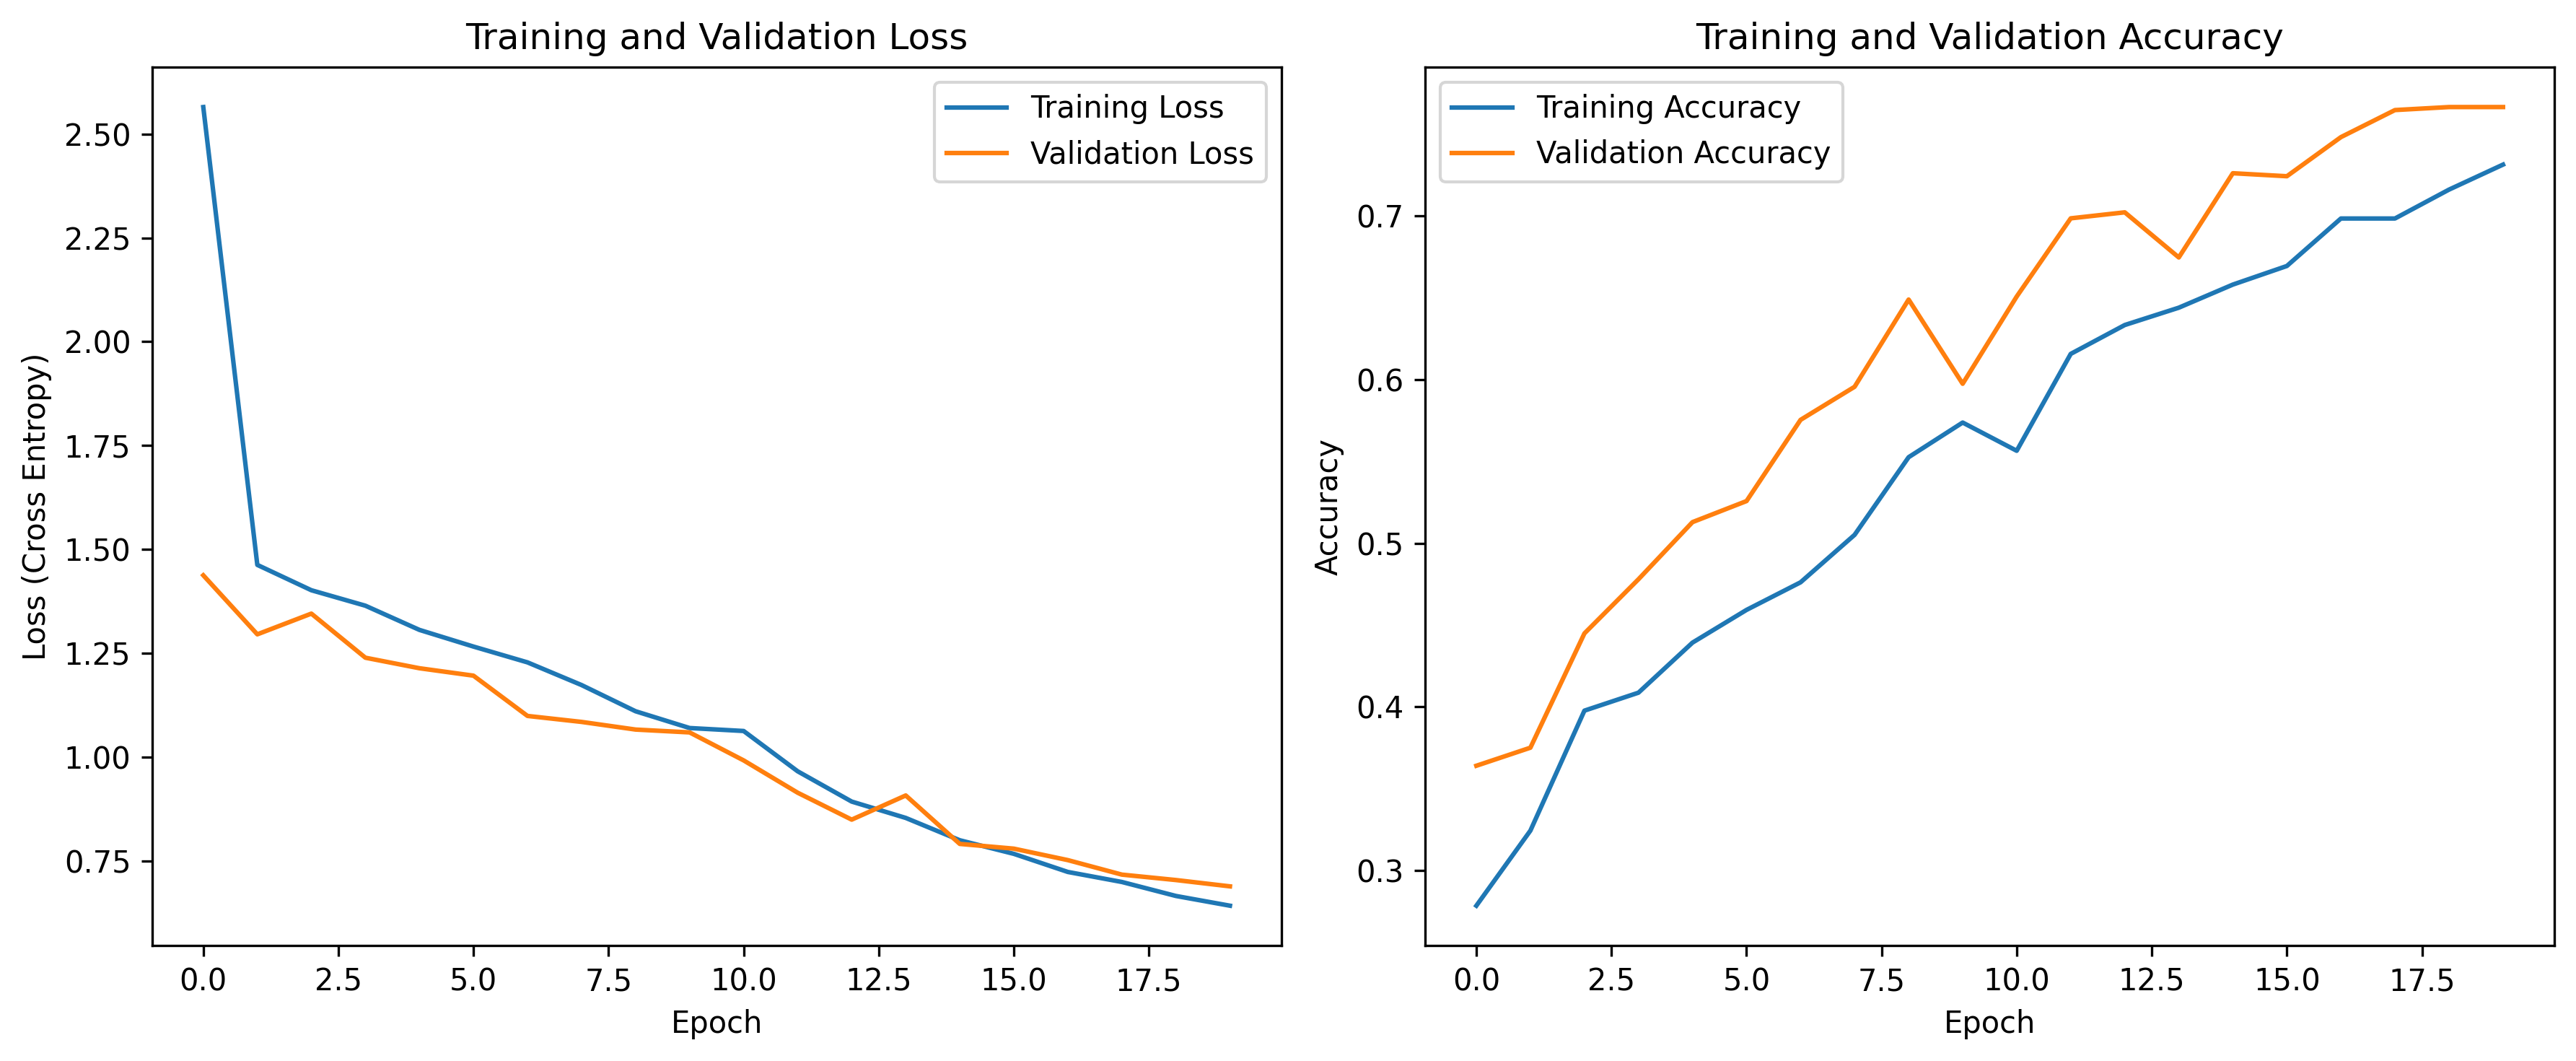

18/18 [==============================] - 4s 73ms/step


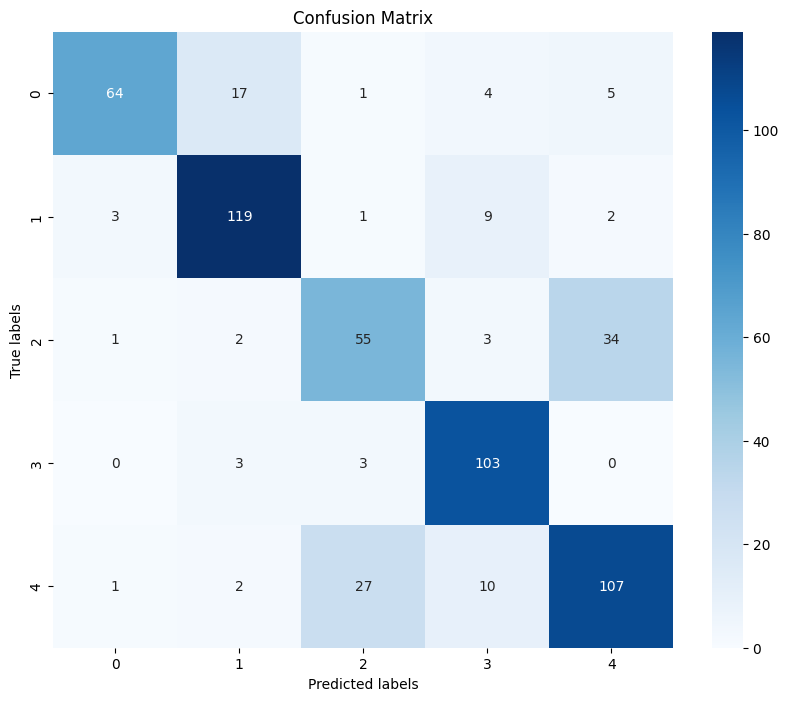

              precision    recall  f1-score   support

     Class 0       0.93      0.70      0.80        91
     Class 1       0.83      0.89      0.86       134
     Class 2       0.63      0.58      0.60        95
     Class 3       0.80      0.94      0.87       109
     Class 4       0.72      0.73      0.73       147

    accuracy                           0.78       576
   macro avg       0.78      0.77      0.77       576
weighted avg       0.78      0.78      0.77       576



In [61]:
# calling the function to plot loss, accuracy, and the confusion matrix.
plot_loss_acc_cm(history, model, test_ds)

# Switched from Max to Average Pooling

In [62]:
# changing the pooling through the config file
config['pooling'] = "AveragePooling2D"

In [63]:
# calling the load_and_prepare_data function with the specified parameters
train_ds, val_ds, test_ds = load_and_prepare_data(
    directory=config['directory'],   # Specifying the directory path from the configuration
    img_size=config['img_size'],     # Specifying the image size from the configuration
    batch_size=config['batch_size']  # Specifying the batch size from the configuration
)

Found 3670 files belonging to 5 classes.


In [64]:
#calling the create_model function with the specified configuration
model = create_model(config)

In [65]:
# Training the model with the specified training and validation datasets.
# The number of training cycles (epochs) is determined by the configuration.
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset for performance evaluation
    epochs=config['epochs']  # Number of epochs to train the model
)

Epoch 1/20
80/80 [==============================] - 26s 270ms/step - loss: 3.1451 - accuracy: 0.2267 - val_loss: 1.5445 - val_accuracy: 0.2647
Epoch 2/20
80/80 [==============================] - 18s 225ms/step - loss: 1.5516 - accuracy: 0.2765 - val_loss: 1.4789 - val_accuracy: 0.2886
Epoch 3/20
80/80 [==============================] - 18s 220ms/step - loss: 1.5166 - accuracy: 0.2867 - val_loss: 1.4567 - val_accuracy: 0.3621
Epoch 4/20
80/80 [==============================] - 18s 228ms/step - loss: 1.4814 - accuracy: 0.3290 - val_loss: 1.4464 - val_accuracy: 0.3879
Epoch 5/20
80/80 [==============================] - 17s 217ms/step - loss: 1.4175 - accuracy: 0.4106 - val_loss: 1.2712 - val_accuracy: 0.4779
Epoch 6/20
80/80 [==============================] - 18s 222ms/step - loss: 1.3169 - accuracy: 0.4561 - val_loss: 1.2781 - val_accuracy: 0.4761
Epoch 7/20
80/80 [==============================] - 18s 225ms/step - loss: 1.3028 - accuracy: 0.4569 - val_loss: 1.2159 - val_accuracy: 0.5331

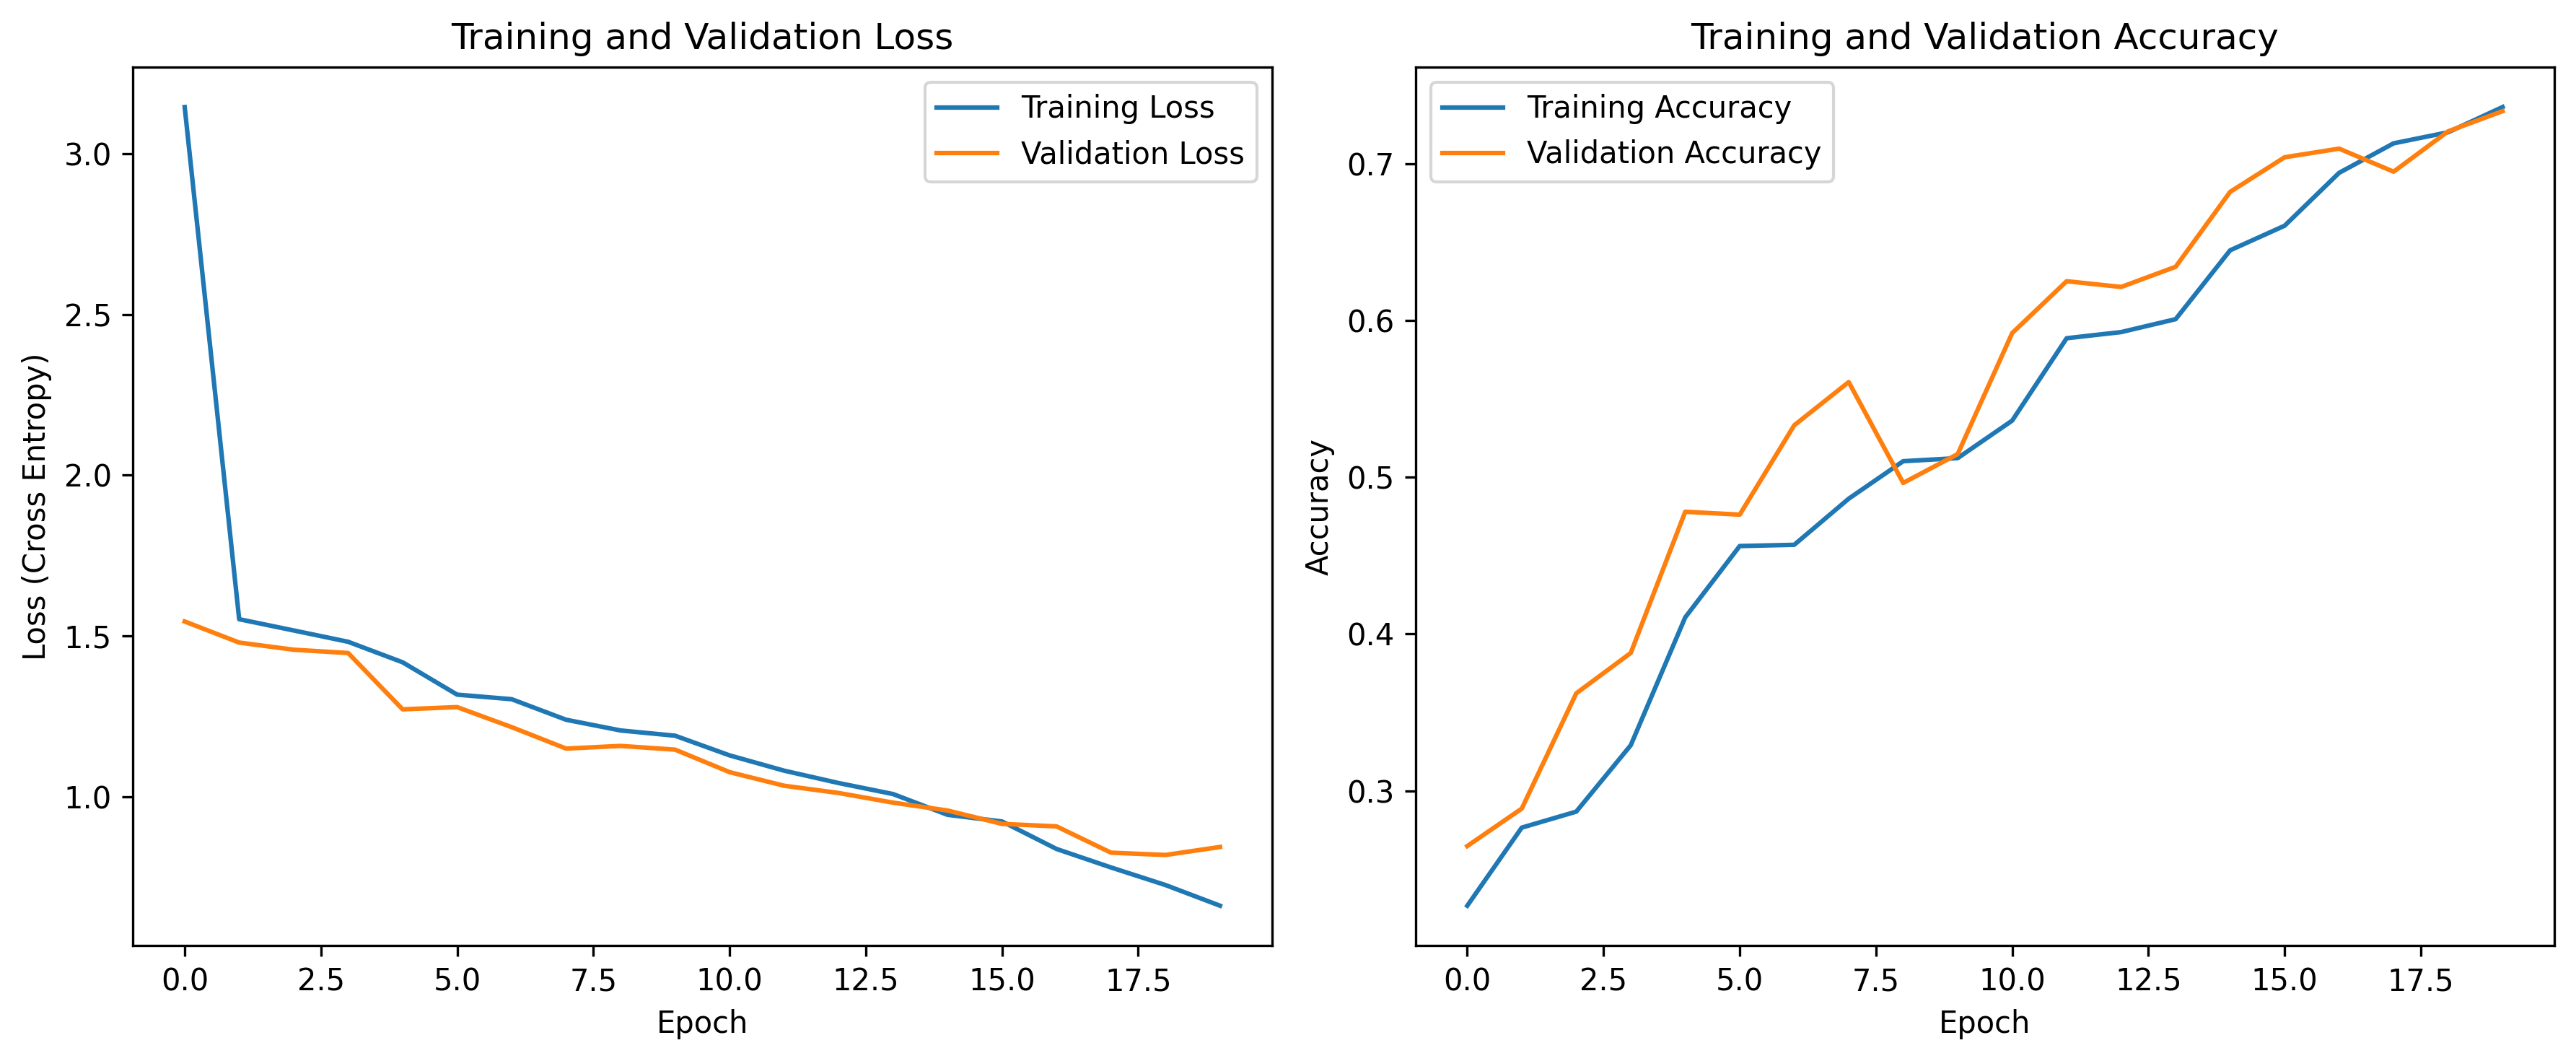

18/18 [==============================] - 21s 74ms/step


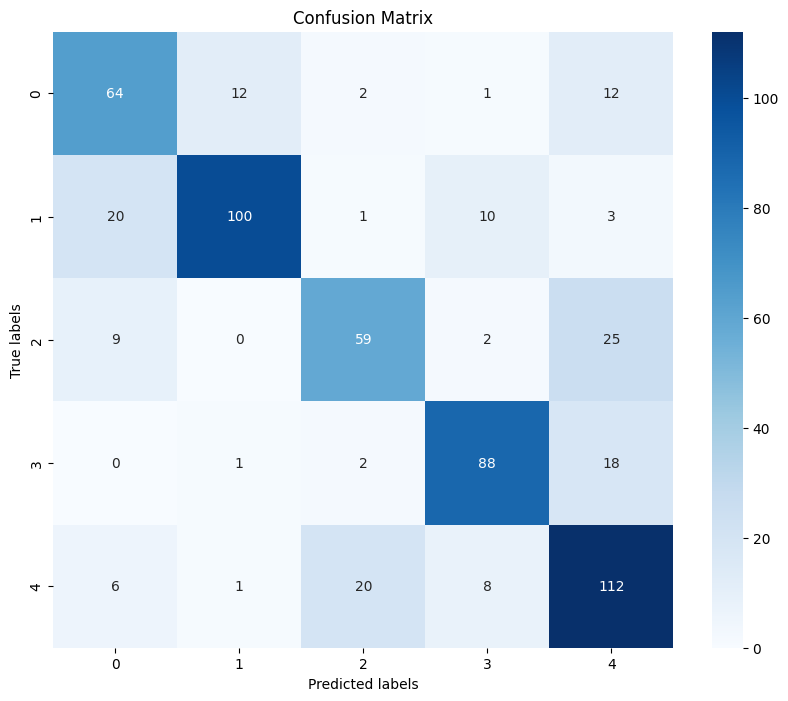

              precision    recall  f1-score   support

     Class 0       0.65      0.70      0.67        91
     Class 1       0.88      0.75      0.81       134
     Class 2       0.70      0.62      0.66        95
     Class 3       0.81      0.81      0.81       109
     Class 4       0.66      0.76      0.71       147

    accuracy                           0.73       576
   macro avg       0.74      0.73      0.73       576
weighted avg       0.74      0.73      0.74       576



In [66]:
# calling the function to plot loss, accuracy, and the confusion matrix.
plot_loss_acc_cm(history, model, test_ds)

# Reverting to Max Pooling & Increasing Batch Size to 1288

In [67]:
# Changing the pooling type in the config file and increasing the batch size to 128
config['pooling'] = 'MaxPooling2D'
config['batch_size'] = 128

In [68]:
# calling the load_and_prepare_data function with the specified parameters
train_ds, val_ds, test_ds = load_and_prepare_data(
    directory=config['directory'],   # Specifying the directory path from the configuration
    img_size=config['img_size'],     # Specifying the image size from the configuration
    batch_size=config['batch_size']  # Specifying the batch size from the configuration
)

Found 3670 files belonging to 5 classes.


In [69]:
#calling the create_model function with the specified configuration
model = create_model(config)

In [70]:
# Training the model with the specified training and validation datasets.
# The number of training cycles (epochs) is determined by the configuration.
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset for performance evaluation
    epochs=config['epochs']  # Number of epochs to train the model
)

Epoch 1/20
20/20 [==============================] - 41s 1s/step - loss: 6.4500 - accuracy: 0.2601 - val_loss: 1.4942 - val_accuracy: 0.2832
Epoch 2/20
20/20 [==============================] - 18s 902ms/step - loss: 1.5027 - accuracy: 0.3276 - val_loss: 1.4537 - val_accuracy: 0.3691
Epoch 3/20
20/20 [==============================] - 18s 897ms/step - loss: 1.4354 - accuracy: 0.4079 - val_loss: 1.3191 - val_accuracy: 0.4668
Epoch 4/20
20/20 [==============================] - 17s 851ms/step - loss: 1.3580 - accuracy: 0.4543 - val_loss: 1.2762 - val_accuracy: 0.4609
Epoch 5/20
20/20 [==============================] - 18s 897ms/step - loss: 1.2834 - accuracy: 0.4762 - val_loss: 1.1713 - val_accuracy: 0.5195
Epoch 6/20
20/20 [==============================] - 17s 877ms/step - loss: 1.1992 - accuracy: 0.5024 - val_loss: 1.1124 - val_accuracy: 0.5547
Epoch 7/20
20/20 [==============================] - 17s 834ms/step - loss: 1.1398 - accuracy: 0.5179 - val_loss: 1.0646 - val_accuracy: 0.5840
Ep

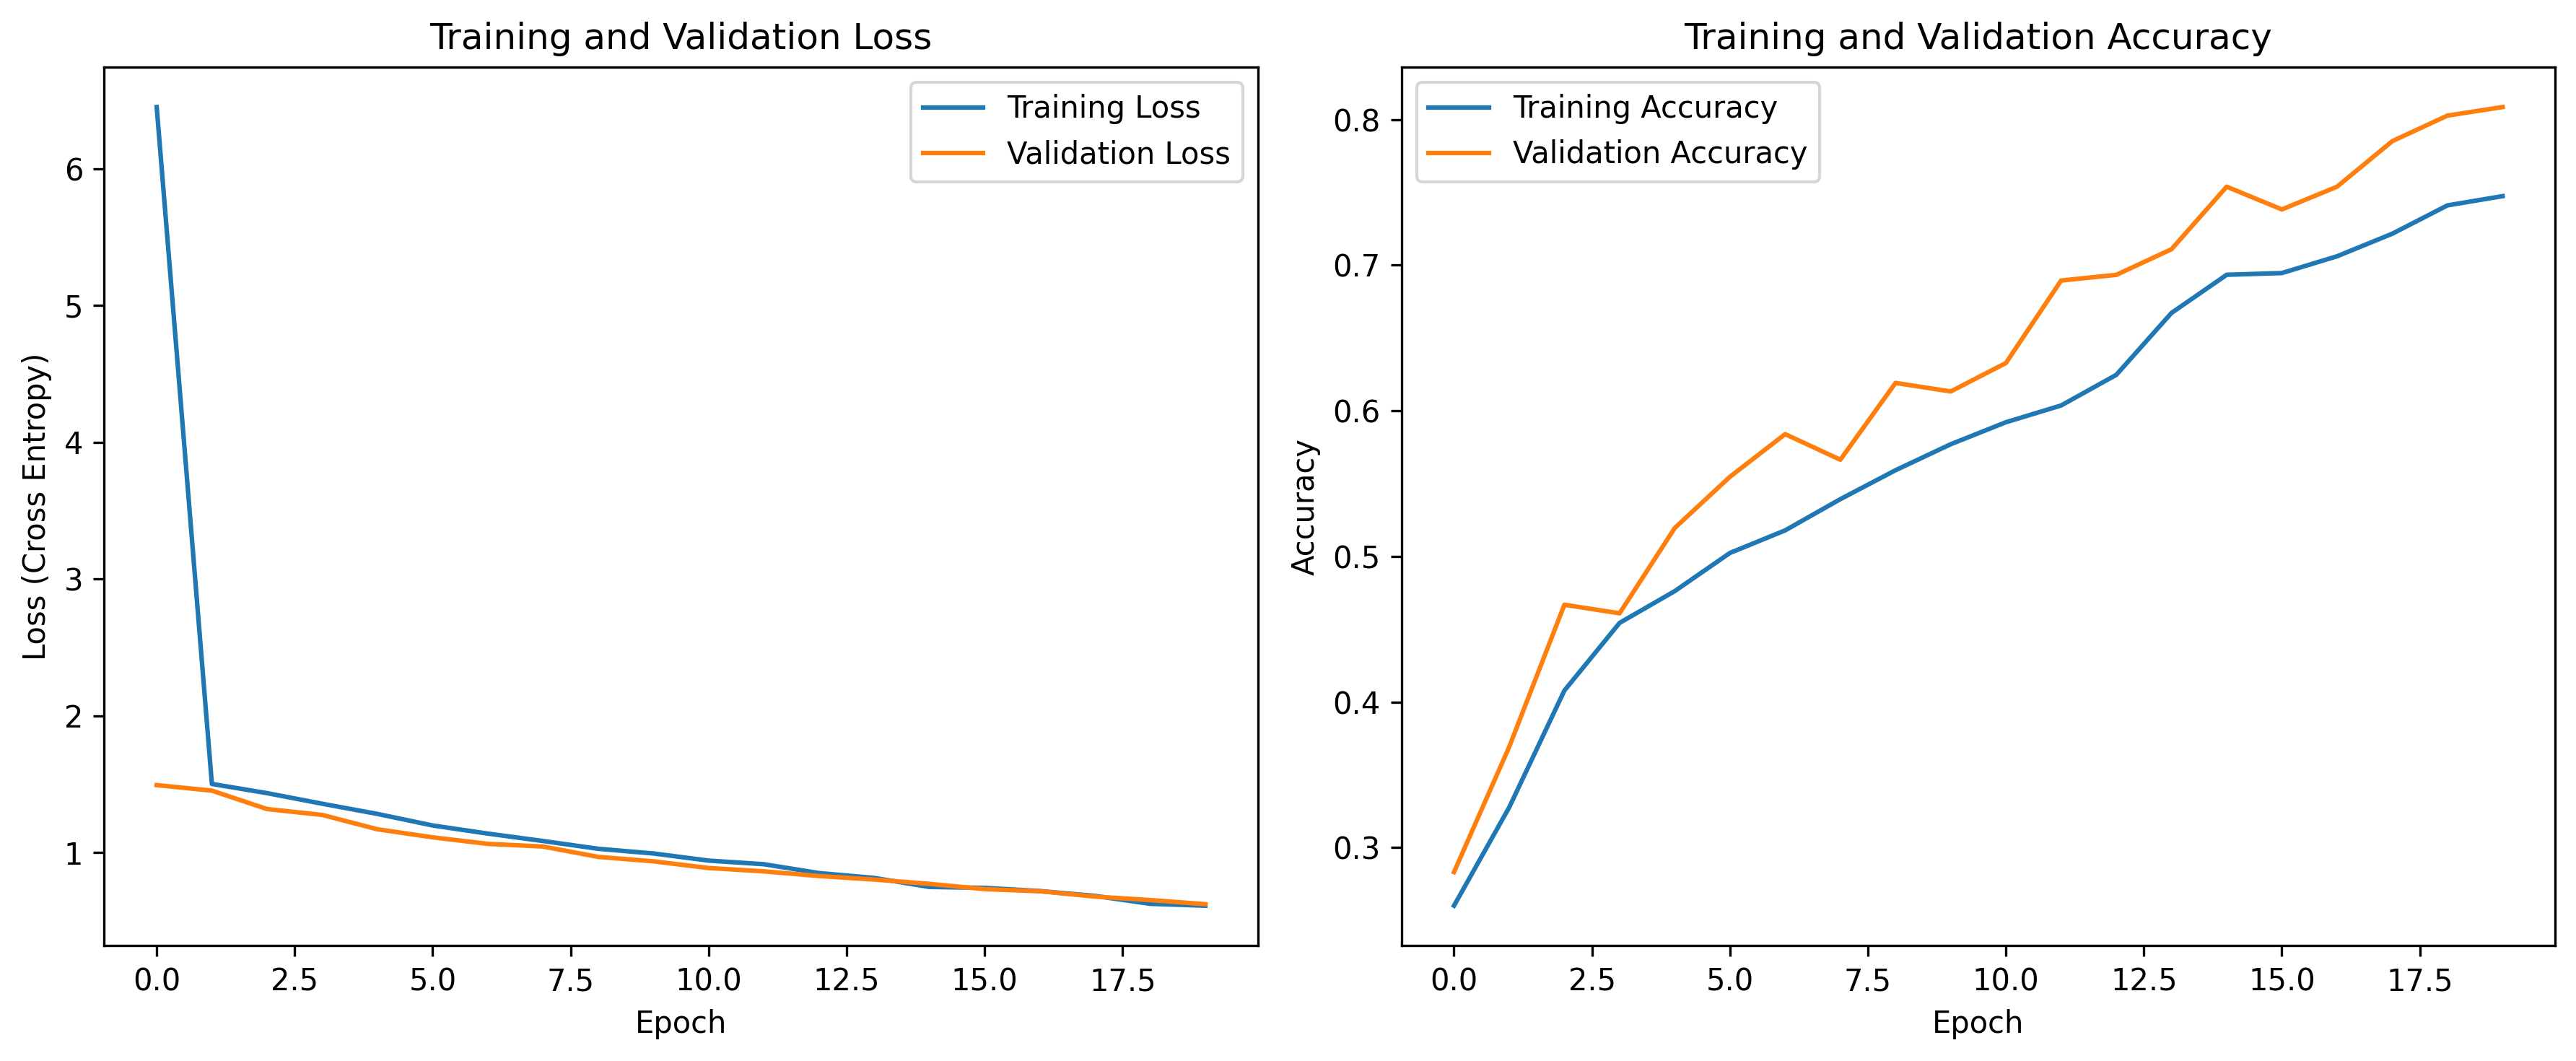

5/5 [==============================] - 19s 251ms/step


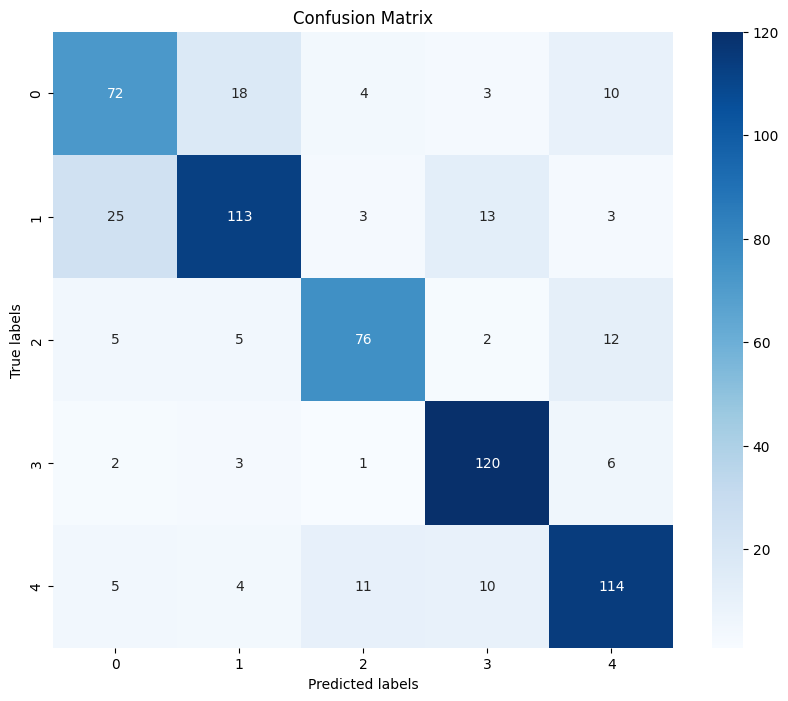

              precision    recall  f1-score   support

     Class 0       0.66      0.67      0.67       107
     Class 1       0.79      0.72      0.75       157
     Class 2       0.80      0.76      0.78       100
     Class 3       0.81      0.91      0.86       132
     Class 4       0.79      0.79      0.79       144

    accuracy                           0.77       640
   macro avg       0.77      0.77      0.77       640
weighted avg       0.77      0.77      0.77       640



In [71]:
# calling the function to plot loss, accuracy, and the confusion matrix.
plot_loss_acc_cm(history, model, test_ds)

## Batch Size: Increased to 128 for more efficient training.
## Dropout Rate: Set to 0.2 to prevent overfitting.
## Learning Rate: Adjusted to 0.001 to balance training speed and model convergence.

In [72]:
# reducing the learning rate to 128 and poolng type back to Max pooling
config['pooling'] = 'MaxPooling2D'
config['learning_rate'] = 0.001

In [73]:
# calling the load_and_prepare_data function with the specified parameters
train_ds, val_ds, test_ds = load_and_prepare_data(
    directory=config['directory'],   # Specifying the directory path from the configuration
    img_size=config['img_size'],     # Specifying the image size from the configuration
    batch_size=config['batch_size']  # Specifying the batch size from the configuration
)

Found 3670 files belonging to 5 classes.


In [74]:
model = create_model(config)                                                                                    

In [75]:
# Training the model with the specified training and validation datasets.
# The number of training cycles (epochs) is determined by the configuration.
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset for performance evaluation
    epochs=config['epochs']  # Number of epochs to train the model
)

Epoch 1/20
20/20 [==============================] - 24s 1s/step - loss: 5.3694 - accuracy: 0.2971 - val_loss: 1.3209 - val_accuracy: 0.4727
Epoch 2/20
20/20 [==============================] - 17s 840ms/step - loss: 1.3667 - accuracy: 0.4079 - val_loss: 1.2259 - val_accuracy: 0.5371
Epoch 3/20
20/20 [==============================] - 16s 826ms/step - loss: 1.2426 - accuracy: 0.4738 - val_loss: 1.1342 - val_accuracy: 0.6113
Epoch 4/20
20/20 [==============================] - 17s 851ms/step - loss: 1.1603 - accuracy: 0.5298 - val_loss: 1.0672 - val_accuracy: 0.6191
Epoch 5/20
20/20 [==============================] - 17s 860ms/step - loss: 1.0729 - accuracy: 0.5576 - val_loss: 0.9587 - val_accuracy: 0.6543
Epoch 6/20
20/20 [==============================] - 16s 814ms/step - loss: 0.9909 - accuracy: 0.6013 - val_loss: 0.9177 - val_accuracy: 0.6680
Epoch 7/20
20/20 [==============================] - 16s 826ms/step - loss: 0.8989 - accuracy: 0.6370 - val_loss: 0.8273 - val_accuracy: 0.6953
Ep

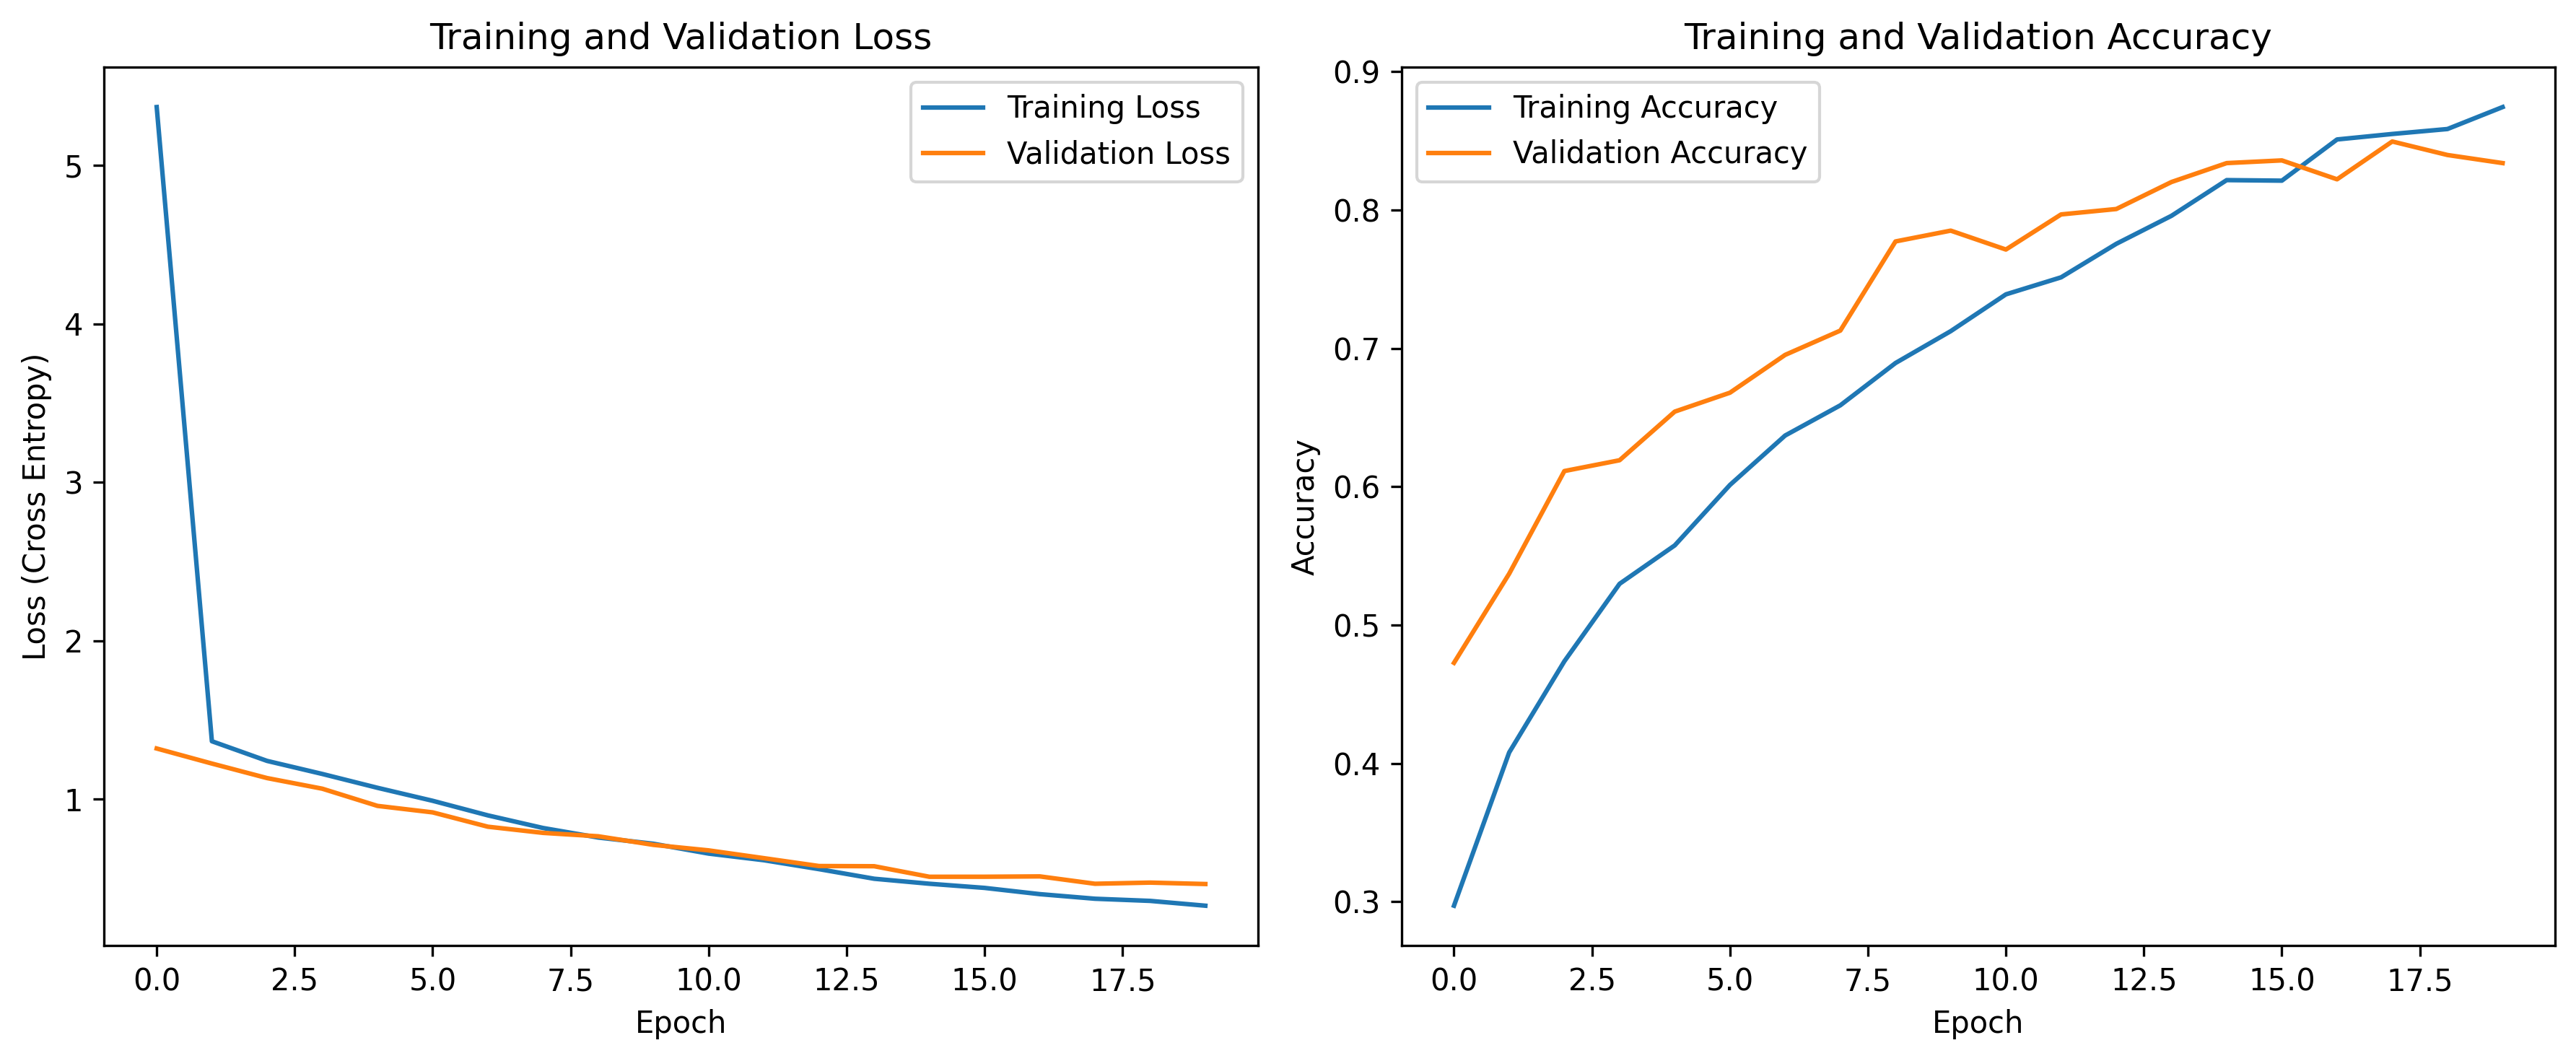

5/5 [==============================] - 4s 252ms/step


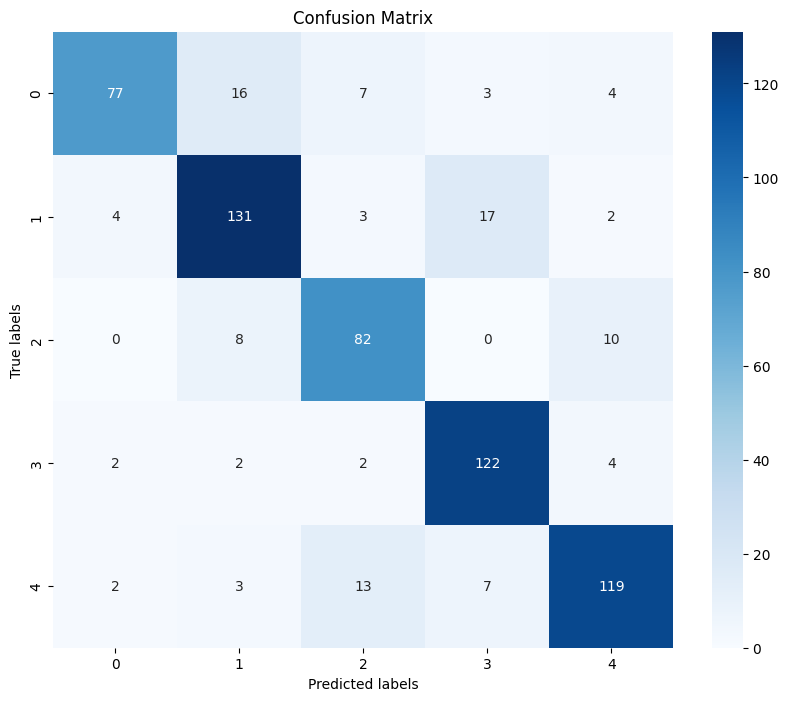

              precision    recall  f1-score   support

     Class 0       0.91      0.72      0.80       107
     Class 1       0.82      0.83      0.83       157
     Class 2       0.77      0.82      0.79       100
     Class 3       0.82      0.92      0.87       132
     Class 4       0.86      0.83      0.84       144

    accuracy                           0.83       640
   macro avg       0.83      0.82      0.83       640
weighted avg       0.83      0.83      0.83       640



In [76]:
# calling the function to plot loss, accuracy, and the confusion matrix.
plot_loss_acc_cm(history, model, test_ds)

## Batch Size: Maintained at 128 for efficient training.
## Dropout Rate: Kept at 0.2 to minimize overfitting.
## Learning Rate: Remains at 0.001 for optimal convergence.
## Batch Normalization: Now enabled to improve network stability and performanc

In [77]:
config

{'directory': 'flower_photos',
 'num_classes': 5,
 'img_size': (180, 180),
 'batch_size': 128,
 'epochs': 20,
 'learning_rate': 0.001,
 'conv_layers': [{'filters': 32,
   'kernel_size': (2, 2),
   'strides': 1,
   'padding': 'valid'}],
 'dense_layers': [64],
 'optimizer': 'adam',
 'train_split': 0.7,
 'val_split': 0.15,
 'metrics': ['accuracy'],
 'dropout_rate': 0.2,
 'pooling': 'MaxPooling2D',
 'use_batch_normalization': False,
 'batch_normalization_momentum': 0.9}

In [84]:
config['learning_rate'] = 0.001
config['batch size'] = 128
config['use_batch_normalization'] = True

In [85]:
# Training the model with the specified training and validation datasets.
# The number of training cycles (epochs) is determined by the configuration.
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset for performance evaluation
    epochs=config['epochs']  # Number of epochs to train the model
)

Found 3670 files belonging to 5 classes.


In [86]:
#calling the create_model function with the specified configuration
model = create_model(config)

In [87]:
# Training the model with the specified training and validation datasets.
# The number of training cycles (epochs) is determined by the configuration.
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset for performance evaluation
    epochs=config['epochs']  # Number of epochs to train the model
)

Epoch 1/20
20/20 [==============================] - 44s 1s/step - loss: 10.4583 - accuracy: 0.3872 - val_loss: 1.7007 - val_accuracy: 0.2969
Epoch 2/20
20/20 [==============================] - 21s 1s/step - loss: 2.5008 - accuracy: 0.4555 - val_loss: 1.5344 - val_accuracy: 0.3340
Epoch 3/20
20/20 [==============================] - 21s 1s/step - loss: 1.4877 - accuracy: 0.4786 - val_loss: 1.3761 - val_accuracy: 0.4766
Epoch 4/20
20/20 [==============================] - 21s 1s/step - loss: 1.2154 - accuracy: 0.5314 - val_loss: 1.2314 - val_accuracy: 0.5781
Epoch 5/20
20/20 [==============================] - 21s 1s/step - loss: 1.0446 - accuracy: 0.5862 - val_loss: 1.3184 - val_accuracy: 0.6152
Epoch 6/20
20/20 [==============================] - 20s 998ms/step - loss: 0.9085 - accuracy: 0.6195 - val_loss: 1.3839 - val_accuracy: 0.6270
Epoch 7/20
20/20 [==============================] - 20s 992ms/step - loss: 0.9452 - accuracy: 0.6465 - val_loss: 1.2778 - val_accuracy: 0.6621
Epoch 8/20
20

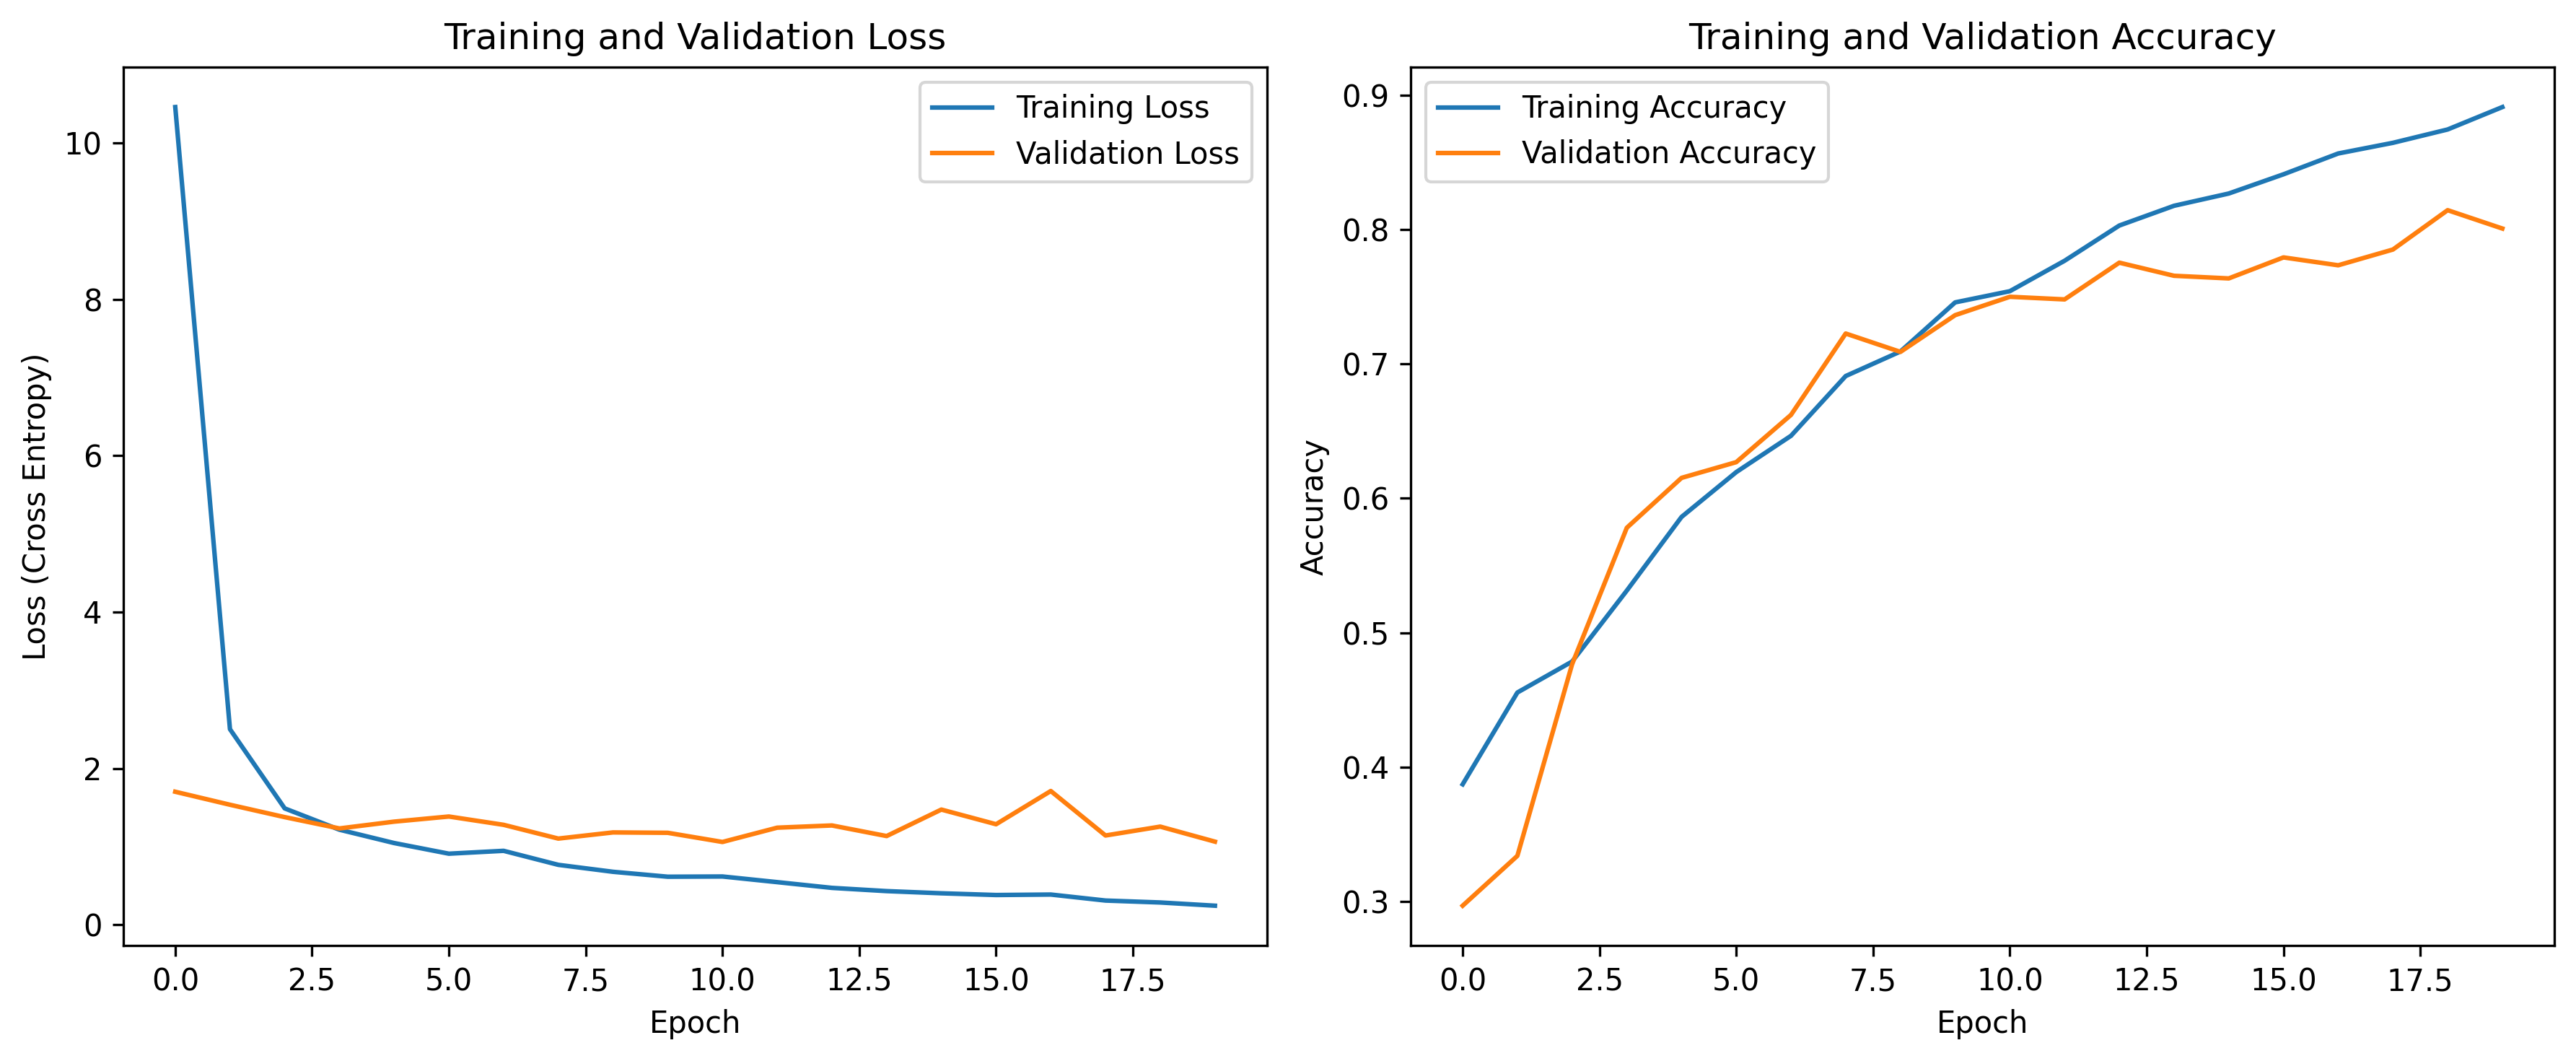

5/5 [==============================] - 5s 291ms/step


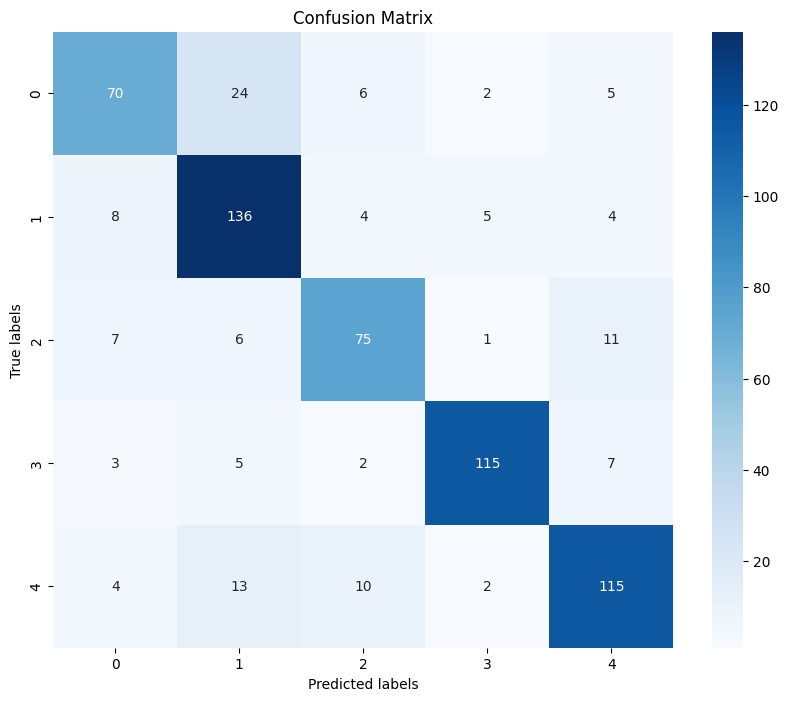

              precision    recall  f1-score   support

     Class 0       0.76      0.65      0.70       107
     Class 1       0.74      0.87      0.80       157
     Class 2       0.77      0.75      0.76       100
     Class 3       0.92      0.87      0.89       132
     Class 4       0.81      0.80      0.80       144

    accuracy                           0.80       640
   macro avg       0.80      0.79      0.79       640
weighted avg       0.80      0.80      0.80       640



In [88]:
# calling the function to plot loss, accuracy, and the confusion matrix.
plot_loss_acc_cm(history, model, test_ds)